<center>
<h1><b>Revealing the Mechanism of WeChat Red Envelopes<b>
</center>

<center>
 Lei Qian 2024533134
</center>
<center>
 Jingqi Xu 2024533083
</center>
<center>
 Zihao Zhang 2024533113
</center>

<center>
date:2025/12/08 
</center>

## **1.Observation**

  To ensure the representativeness and comprehensiveness of the data, experimental scenarios with "WeChat group size" as the core variable are designed, covering two typical scales:

**3-person (small private group)**

Focus on exploring the red envelope distribution pattern in intimate, small-scale interaction scenarios. The total red envelope amount is fixed at 20 yuan, and the experiment is repeated 120 times to ensure the statistical significance of the sample.

**15-person (medium-sized social group)**

Aim to reflect the distribution characteristics in semi-public social scenarios (e.g., friend groups, interest groups). To capture the impact of different total amounts on user behavior, two types of total red envelope amounts are included to enrich the sample diversity: 

1.60 yuan per red envelope, repeated 150 times; 

2.0.6 yuan per red envelope (low-amount scenario), repeated 150 times.

## **2.Visualization**

To intuitively reveal the distribution characteristics, dispersion degree, and correlation between key variables of WeChat red envelope received amounts, this study adopts three types of visualization tools—histograms, box plots, and scatter plots—based on standardized experimental data, with plots generated using Python's matplotlib libraries. The detailed results are as follows:


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator, MaxNLocator
import math
import random
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

In [57]:
def _get_layout_config(n_people):
    if n_people <= 5:
        ncols = n_people
        nrows = 1
        figsize = (5 * ncols, 5) 
    else:
        ncols = 5
        nrows = math.ceil(n_people / ncols)
        figsize = (20, 4 * nrows)
    return nrows, ncols, figsize

def plot_histograms(file_path, n_people, mode="amount"):
    df = pd.read_excel(file_path, sheet_name="Sheet1", header=None)
    plot_data = df.iloc[1:-1, :n_people].values.astype(float)

    if mode == "amount":
        xlabel = "Red Packet Amount (RMB)"

        valid_flat = plot_data[~np.isnan(plot_data)]
        g_min = np.floor(valid_flat.min()) 
        g_max = np.ceil(valid_flat.max())
        bin_width = 0.2 if n_people > 5 else 0.5 
        y_limit = 0.08
        show_stats = True
    else: # mode == "ratio"
        xlabel = "Ratio (Amount / Remaining)"
        g_min, g_max = 0.0, 1.05
        bin_width = 0.01
        y_limit = 0.15
        show_stats = False

    bin_edges = np.arange(g_min, g_max + bin_width, bin_width)
    nrows, ncols, figsize = _get_layout_config(n_people)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    fig.suptitle(f"{mode.capitalize()}-Probability Distribution - {n_people} People", 
                 fontsize=18, fontweight="bold", y=0.98 if nrows > 1 else 1.05)

    colors = cm.Set3(np.linspace(0, 1, n_people))
    if n_people == 1: axes_flat = [axes]
    elif nrows == 1: axes_flat = axes
    else: axes_flat = axes.flat

    stats_list = []
    
    for idx in range(nrows * ncols):
        ax = axes_flat[idx]
        if idx >= n_people:
            ax.set_visible(False); continue
            
        col_data = plot_data[:, idx]
        valid_subset = col_data[~np.isnan(col_data)]
        
        if len(valid_subset) == 0:
            ax.set_visible(False); continue

        valid_subset = np.round(valid_subset, 4)

        # 统计
        mean_val = np.mean(valid_subset)
        stats_list.append({
            "Person": f"P{idx+1}", "Mean": f"{mean_val:.4f}", 
            "Std": f"{np.std(valid_subset):.4f}", "Max": f"{np.max(valid_subset):.4f}"
        })

        # 画图
        freq, _ = np.histogram(valid_subset, bins=bin_edges)
        ax.bar(bin_edges[:-1] + bin_width/2, freq/len(valid_subset), width=bin_width*0.9, 
               color=colors[idx], edgecolor="black", alpha=0.8)

        # 装饰
        if show_stats:
            ax.axvline(mean_val, color="red", ls="--", lw=2, label=f"Mean:{mean_val:.2f}")
            ax.legend(fontsize=8)
        ax.annotate(f"Max:{np.max(valid_subset):.2f}", xy=(0.05, 0.95), xycoords="axes fraction",
                    fontsize=9, color="darkred", bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.6))
        
        ax.set_xlim(g_min, g_max)
        ax.set_ylim(0, y_limit)
        ax.set_title(f"Person {idx+1}", fontweight="bold")
        if idx % ncols == 0: ax.set_ylabel("Probability")
        if idx >= n_people - ncols: ax.set_xlabel(xlabel)

    plt.tight_layout()
    plt.show()
    print(pd.DataFrame(stats_list).to_string(index=False))

In [38]:
def plot_trends(file_path, n_people):
    """
    绘制趋势图：包含 箱线图 (Boxplot) 和 散点图 (Scatter)
    """
    df = pd.read_excel(file_path, sheet_name="Sheet1", header=None)
    data = df.iloc[1:-1, :n_people].values.astype(float)
    
    plot_data = [data[:, i][~np.isnan(data[:, i])] for i in range(n_people)]
    labels = [f"P{i+1}" for i in range(n_people)]
    colors = cm.Set3(np.linspace(0, 1, n_people))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(max(12, n_people), 6))
    
    bp = ax1.boxplot(plot_data, patch_artist=True, tick_labels=labels, showmeans=True,
                     meanprops={"marker":"o", "mfc":"red"}, medianprops={"color":"black"})
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax1.set_title("Amount Distribution (Boxplot)", fontsize=14, fontweight="bold")
    ax1.set_ylabel("RMB")
    ax1.grid(axis='y', alpha=0.3)
    
    x_vals, y_vals, c_vals = [], [], []
    mean_trend = []
    
    for i, p_data in enumerate(plot_data):
        x_jitter = np.random.uniform(i+1-0.1, i+1+0.1, size=len(p_data))
        x_vals.extend(x_jitter)
        y_vals.extend(p_data)
        c_vals.extend([colors[i]] * len(p_data))
        mean_trend.append(np.mean(p_data))
        
    ax2.scatter(x_vals, y_vals, c=c_vals, alpha=0.6, edgecolors='k', s=30)
    ax2.plot(range(1, n_people+1), mean_trend, "r--o", lw=2, label="Mean Trend")
    
    ax2.set_xticks(range(1, n_people+1))
    ax2.set_xticklabels(labels)
    ax2.set_title("Amount Scatter & Trend", fontsize=14, fontweight="bold")
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

#### **15-person and 60 yuan per red envelope,repeated 150 times** 

##### **1.histograms**



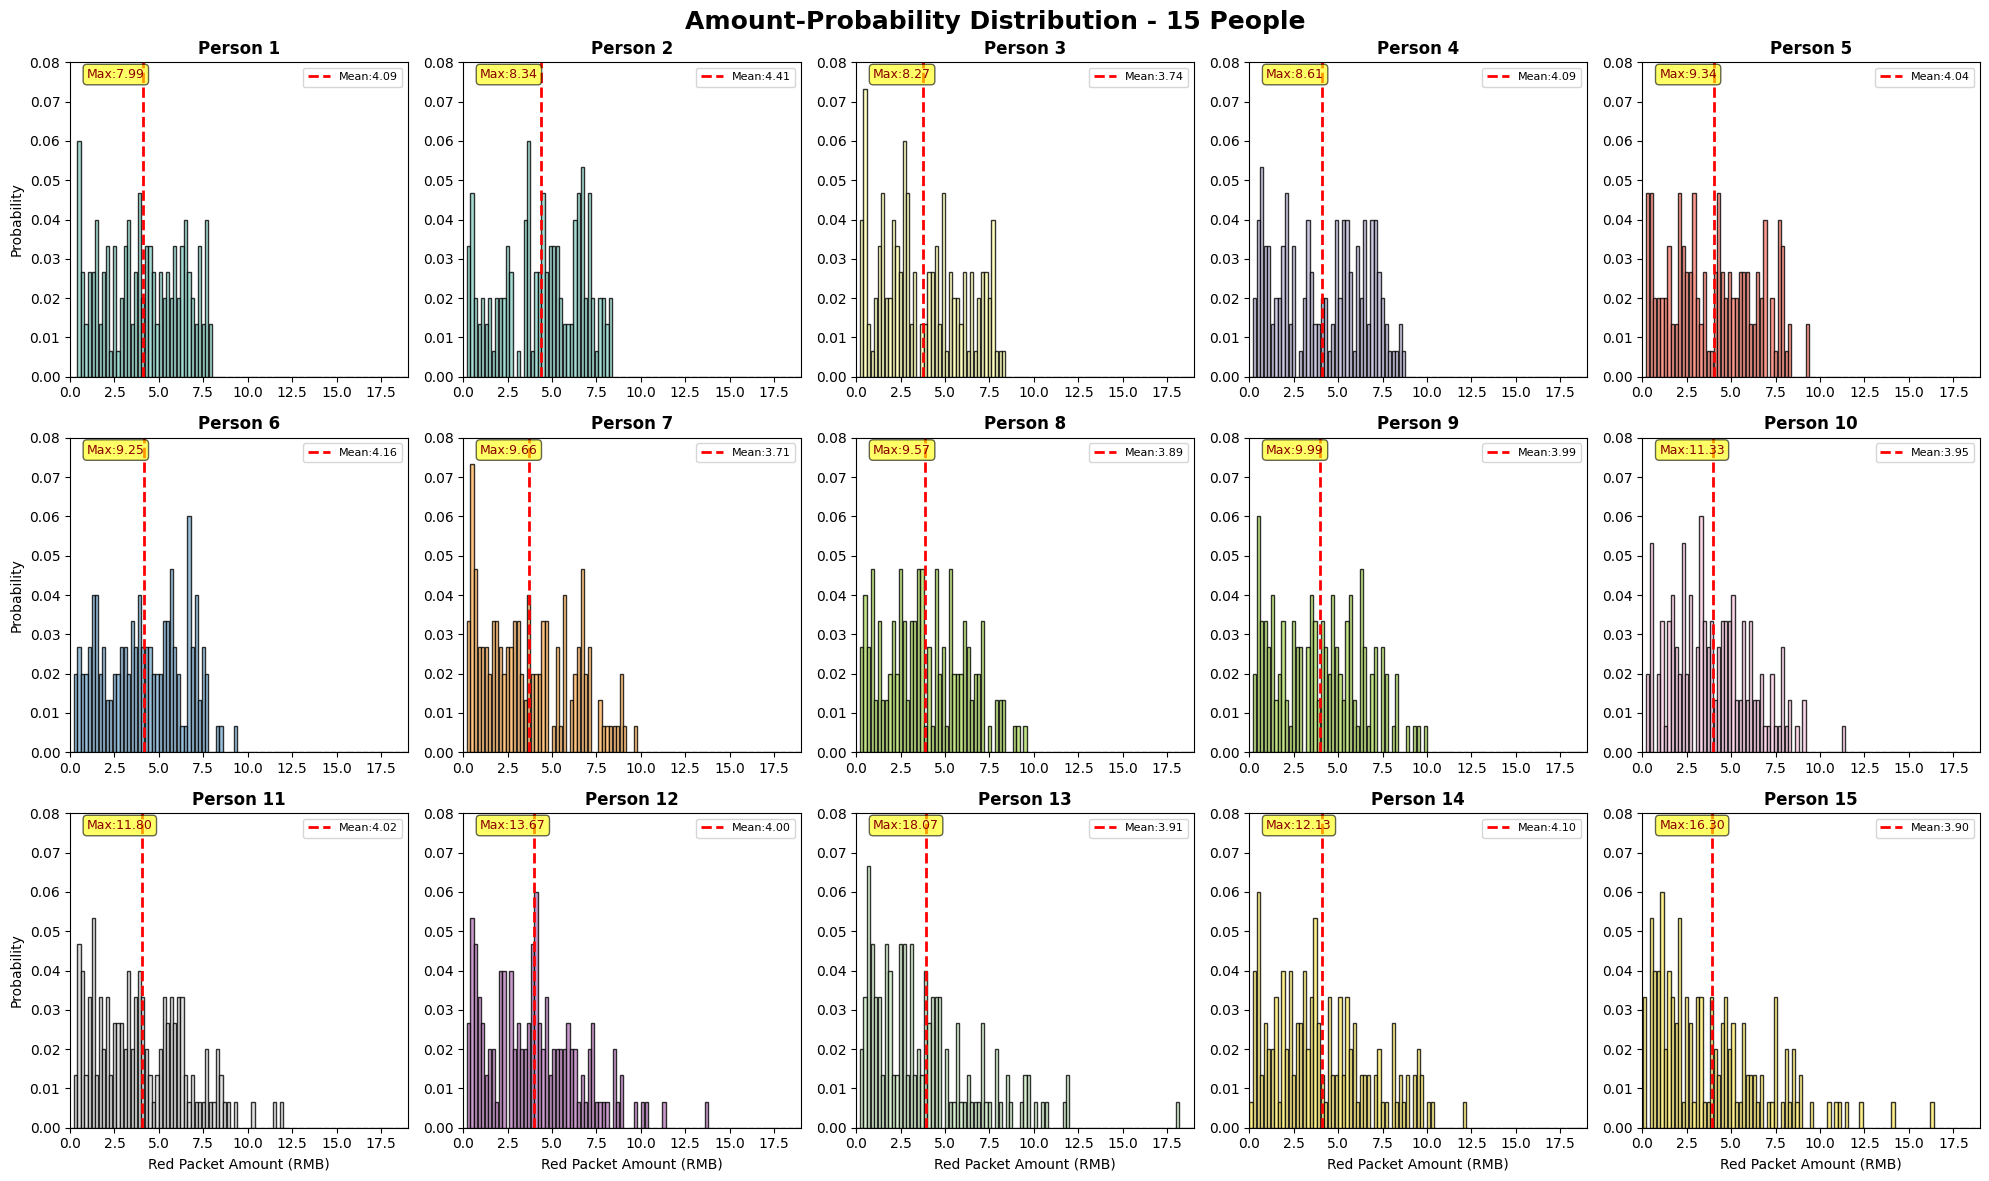

Person   Mean    Std     Max
    P1 4.0865 2.2260  7.9900
    P2 4.4103 2.3059  8.3400
    P3 3.7449 2.3309  8.2700
    P4 4.0859 2.4237  8.6100
    P5 4.0369 2.4357  9.3400
    P6 4.1624 2.2400  9.2500
    P7 3.7135 2.4943  9.6600
    P8 3.8862 2.2836  9.5700
    P9 3.9915 2.4387  9.9900
   P10 3.9515 2.2941 11.3300
   P11 4.0245 2.5385 11.8000
   P12 4.0037 2.6275 13.6700
   P13 3.9077 3.0490 18.0700
   P14 4.0982 2.7706 12.1300
   P15 3.8963 3.1036 16.3000


In [58]:
plot_histograms("../Data/15/15人.xls", 15)

From the graph,we can find

1. The mean amount of all grabbing orders is close to 4 RMB (the theoretical mean of 60 RMB ÷ 15 people), indicating that amounts are concentrated around the theoretical mean regardless of the grabbing order.

2. Early grabbing orders (e.g., Order1-Order5) have smaller standard deviations (2.23-2.44), with more compact amount distributions;Later grabbing orders (e.g., Order10-Order15) have slightly higher standard deviations (2.50-3.05), and their maximum amounts (e.g., Max=18.30 for Order15) are significantly higher than those of early orders, meaning dispersion increases as the grabbing order moves backward.

3. All orders show a right-skewed "dense left, sparse right" pattern—probability is higher in the low-amount range (0-8 RMB) and drops rapidly in the high-amount range, which aligns with the typical random allocation feature of red envelopes.

4. For the data that low than 0.4,there is no any distribution.From this we can suspect that there is a mechanism that force a lower limit for each red envelope.It is rational that the lower limit is related to the rest money.
5. And for each order,we can see that there is a upper limit for them.And when the order increase,the upper limit is increasing.We suspect that the upper limit is related to the rest money and rest players.

To eliminate the effect of the remaining amount, we divided the amount each person received by the current total amount, looking only at the impact of the order on the proportion of money received.

**amount each person receives/remaining amount** histogram

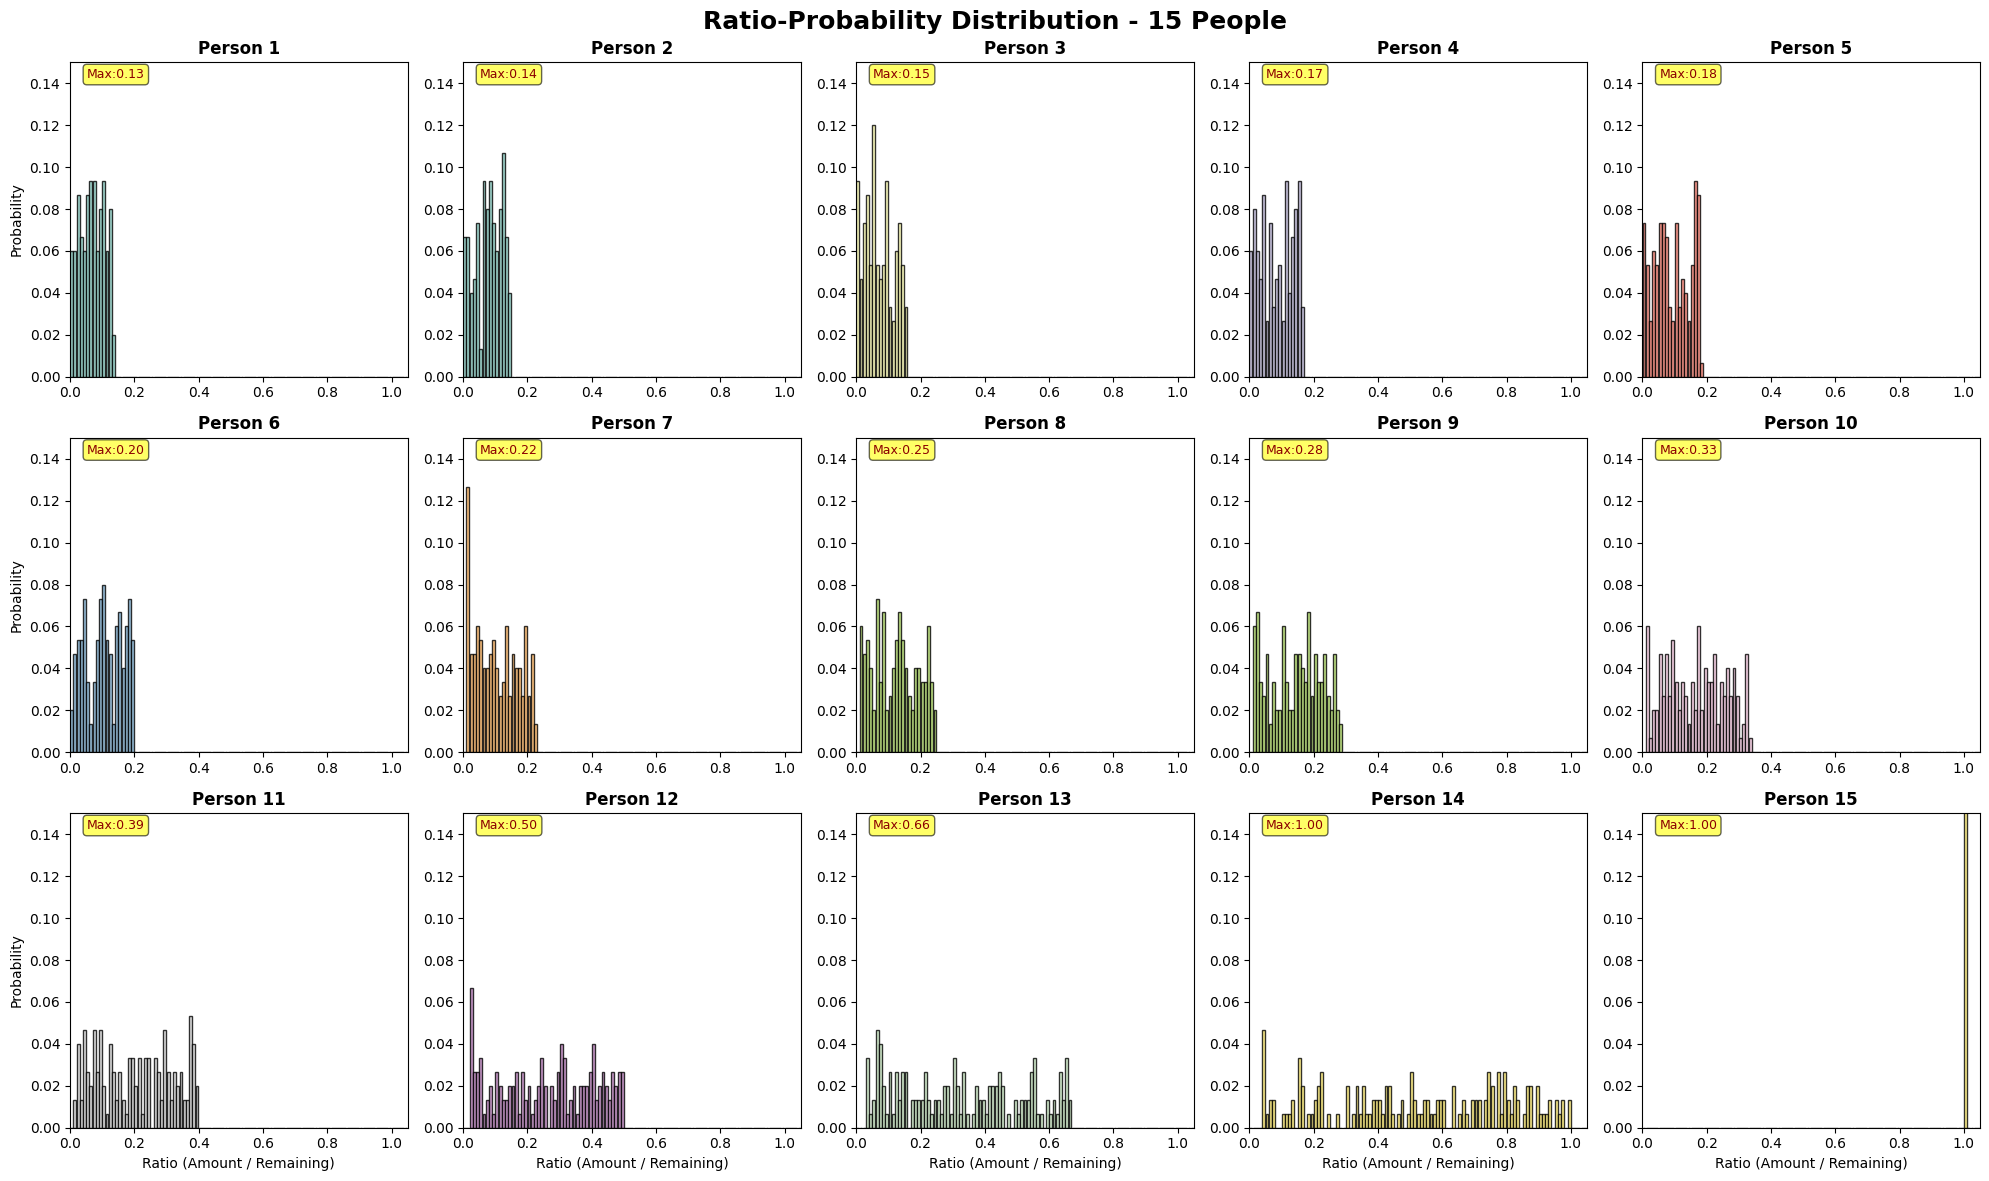

Person   Mean    Std    Max
    P1 0.0681 0.0371 0.1332
    P2 0.0788 0.0411 0.1424
    P3 0.0726 0.0448 0.1533
    P4 0.0857 0.0506 0.1661
    P5 0.0926 0.0552 0.1801
    P6 0.1064 0.0575 0.1988
    P7 0.1038 0.0656 0.2215
    P8 0.1219 0.0690 0.2490
    P9 0.1418 0.0804 0.2827
   P10 0.1671 0.0918 0.3311
   P11 0.2027 0.1165 0.3947
   P12 0.2571 0.1488 0.4973
   P13 0.3238 0.1951 0.6606
   P14 0.5194 0.2819 0.9976
   P15 1.0000 0.0000 1.0000


In [59]:
plot_histograms("../Data/15/15人_ratio.xlsx", 15, mode = "ratio")

From the graph we can find:

1. The ratio upper limit of later grabbing orders (Order2-Order15) increases significantly (Order15 reaches 1.0), indicating that the later one grabs, the higher the proportion of the remaining amount a single grab can account for.

for some special case we can suspect the upper limit:**Order 11 max=0.3947**$\approx$ **0.4**;**Order 12 max=0.4973**$\approx$ **0.5**;**Order 13 max=0.6606**$\approx$ **0.6667**

so we suspect that the **upper limit is $\frac{2}{m}$**,m is the rest number of player.

2. The lower limit is also increasing along with the increase of order.

We observed that here many first-place individuals received 0.4 yuan, which is quite rare. Since 0.4 is 4 divided by 10, and 4 is the average per person, we therefore speculate that the lower limit of the data is the average divided by 10.

Moreover, the bands closest to the lower limit are usually longer, which indicates that if a player is assigned an amount below the lower limit, it is likely to be rounded up to the lower limit.We suspect that the distribution is on the **internval [0,upper limit]**

3. Ratios of all orders are uniform in the interval.It is likely that it can fit the uniform distribution.
   

##### **2.box plots && scatter plots**

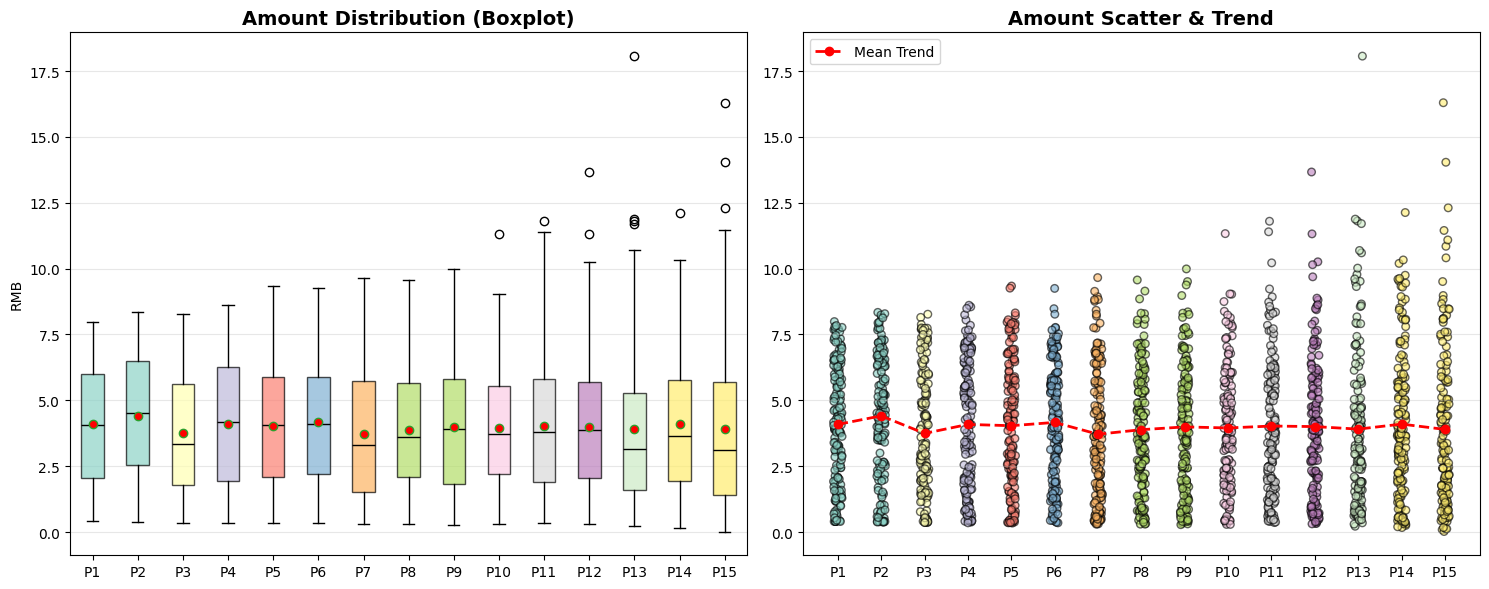

In [44]:
plot_trends("../Data/15/15人.xls", 15)

1.The boxes (interquartile ranges) of early grabbing orders (Order1-Order6) are relatively compact, with small amount fluctuations;

2.The boxes of later grabbing orders (Order10-Order15) widen, and their whiskers (ranges from min to max) extend significantly, with high-value outliers (e.g., the maximum of Order15 exceeds 17 RMB). This means the later one grabs, the greater the amount dispersion.

##### **3.scatter plots—based**

1. Amounts of all grabbing orders are distributed around 4 RMB (the theoretical mean of 60 RMB ÷ 15 people), and the red mean trend line remains basically stable. This indicates that regardless of the grabbing order, the overall average amount aligns with the theoretical mean.

2. Amounts of early grabbing orders (Order1-Order6) are concentrated in the 0-8 RMB range, with a compact distribution;Amounts of later grabbing orders (Order10-Order15) expand to the 0-18 RMB range, and the proportion of high-amount samples (＞10 RMB) increases significantly. Dispersion grows noticeably as the grabbing order moves backward.

3. Extreme high amounts (over 15 RMB) appear in later grabbing orders (e.g., Order13, Order15), further verifying the rule that "amount fluctuations are more intense for later grabs".

The next is the diagram of **3-person 60 yuan per red envelope for 120 times** and **15-person 0.6 yuan per red envelope for 120 times**

They reveal the same patterns as the figure above.***And these data pass the examine of our suspect to lower limit and upper limit.**

#### **3-person 60 yuan per red envelope for 120 times**

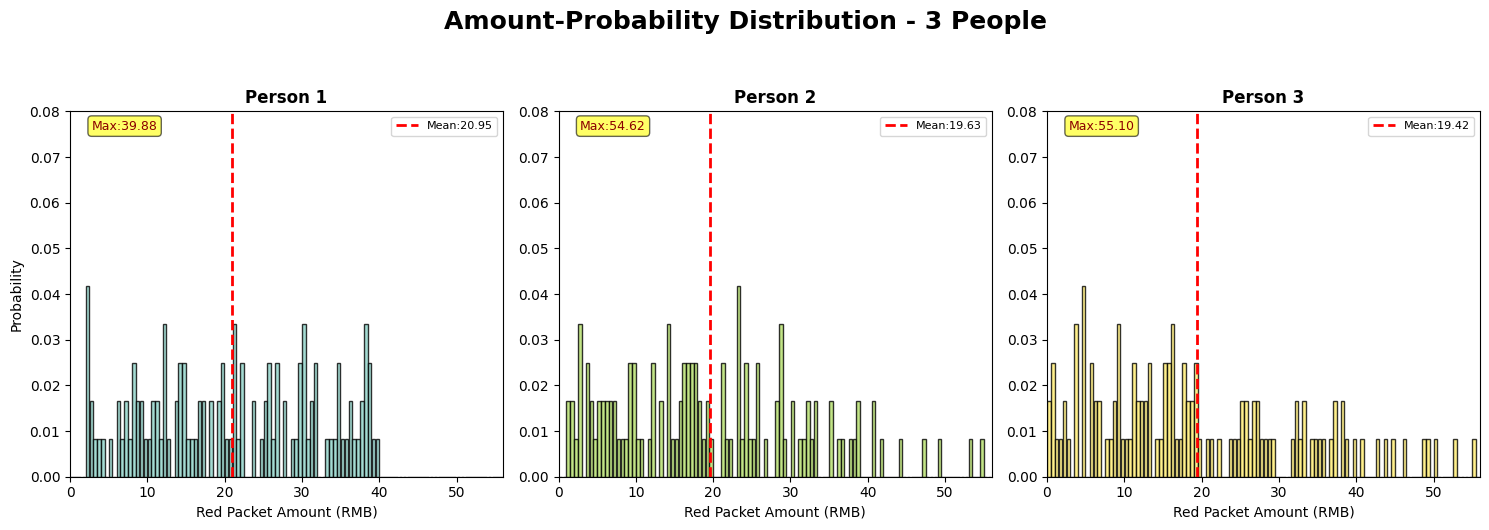

Person    Mean     Std     Max
    P1 20.9504 11.1981 39.8800
    P2 19.6268 12.4343 54.6200
    P3 19.4228 13.5046 55.1000


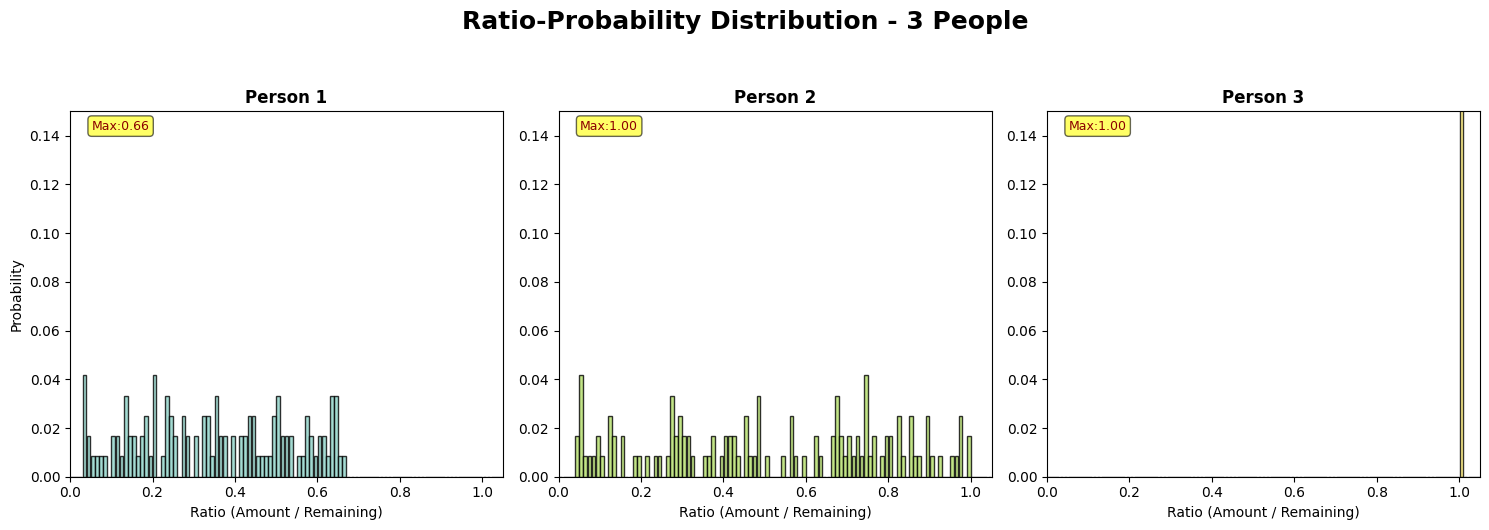

Person   Mean    Std    Max
    P1 0.3492 0.1866 0.6647
    P2 0.5124 0.2834 0.9982
    P3 1.0000 0.0000 1.0000


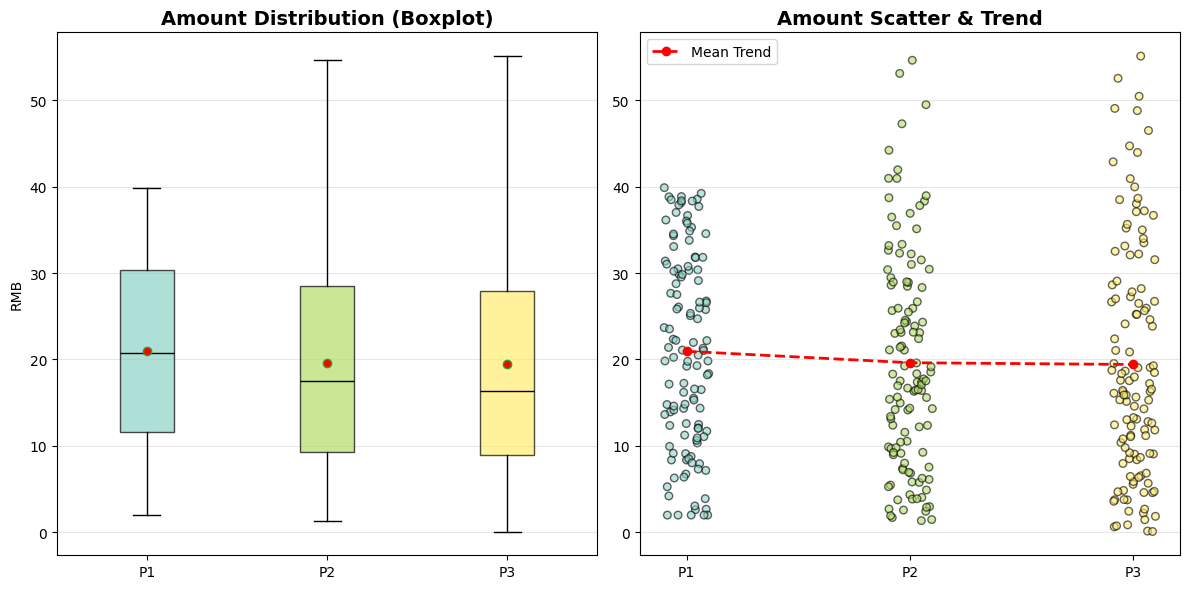

In [60]:
n = 3
plot_histograms("../Data/3/3人总.xls", n)
plot_histograms("../Data/3/3人总_ratio.xlsx", n, mode = "ratio")
plot_trends("../Data/3/3人总.xls", n)

#### **15-person 0.6 yuan per red envelope for 150 times**

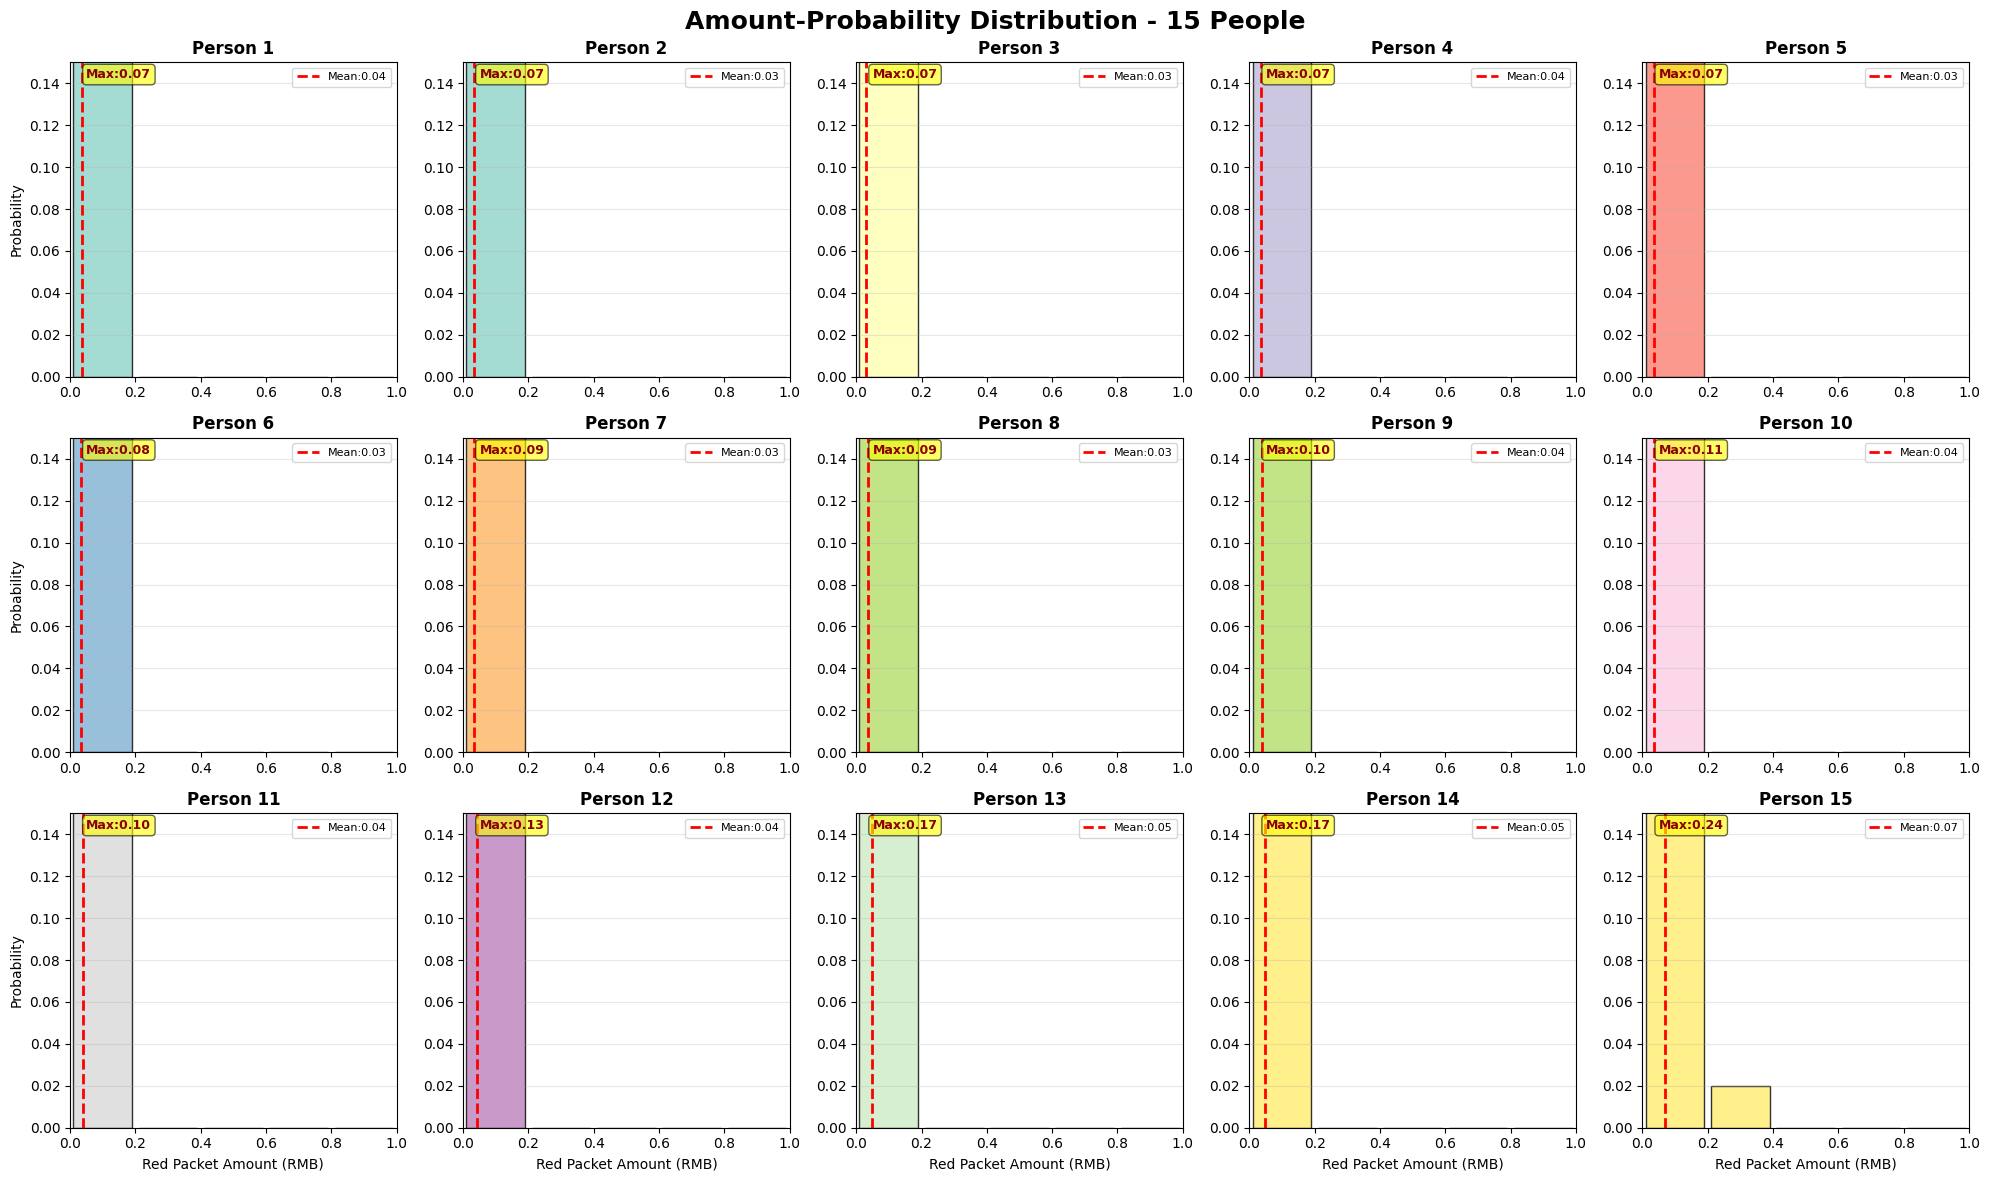

=== Amount Statistics (15 People) ===
Person   N   Mean    Std    Max
    P1 150 0.0373 0.0206 0.0700
    P2 150 0.0319 0.0174 0.0700
    P3 150 0.0313 0.0203 0.0700
    P4 150 0.0363 0.0189 0.0700
    P5 150 0.0343 0.0197 0.0700
    P6 150 0.0348 0.0205 0.0800
    P7 150 0.0345 0.0211 0.0900
    P8 150 0.0349 0.0214 0.0900
    P9 150 0.0385 0.0254 0.1000
   P10 150 0.0360 0.0259 0.1100
   P11 150 0.0405 0.0259 0.1000
   P12 150 0.0434 0.0291 0.1300
   P13 150 0.0483 0.0349 0.1700
   P14 150 0.0481 0.0354 0.1700
   P15 150 0.0699 0.0443 0.2400


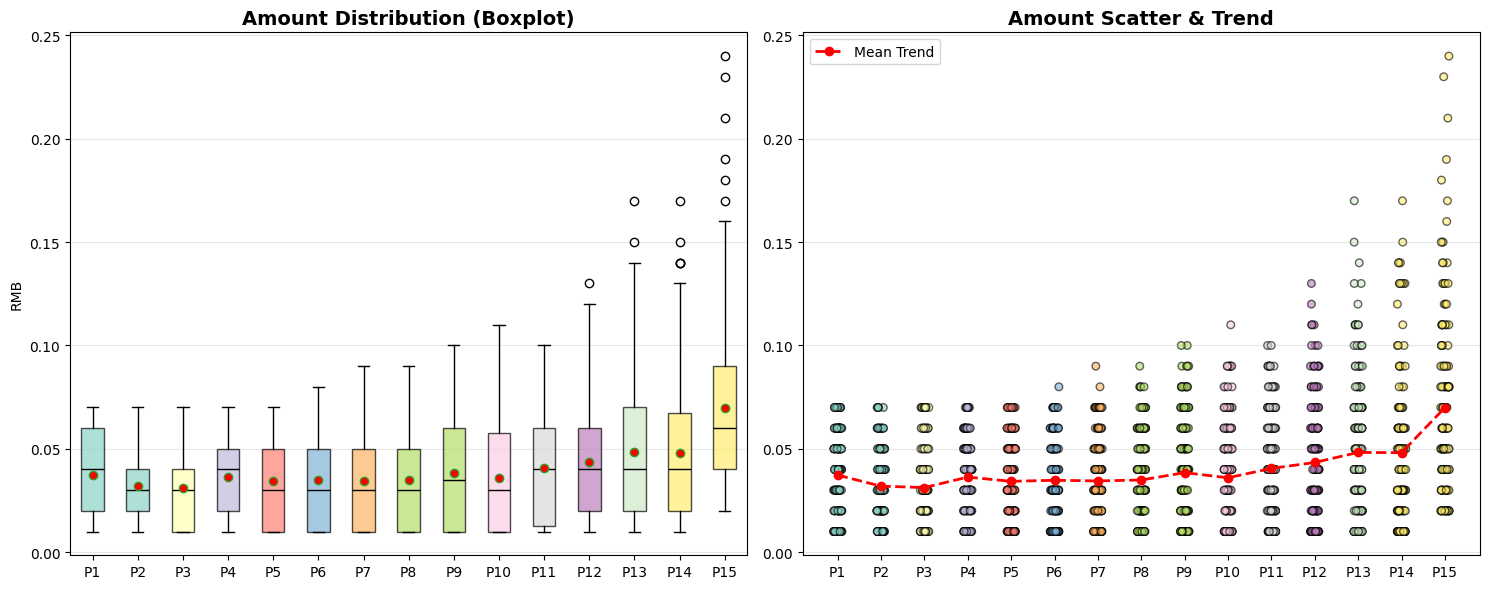

In [45]:
f_path = "../Data/15/15人 0.6.xls"
n = 15
plot_histograms(f_path, n)
plot_trends(f_path, n)

For this set of data samples, we found that their mean is not constant. In the last several sequences, the average amount of money increased significantly. The characteristic of this data set is that the total amount is relatively small, only 0.6 yuan, which is very likely caused by the minimum denomination of the red envelope. Because there is an upper limit, the range of amounts is restricted. This upper limit does not necessarily have a minimum increment of 0.01. This doesn’t have much impact when the total amount is large, but when the total amount is small, for example, if the upper limit is 0.039, then the values can only be between 0.01 and 0.03, which can cause a significant error. The previous people are restricted in the amounts they can take, so if they take smaller amounts, the last several people can take the extra money,so they have higher mean. This also provides strong evidence for our hypothesis that the upper limit is $M\frac{2}{n}$.

#### Conclusion 

1. Whether in 3-person or 15-person groups, the mean grab amount across different grabbing orders is close to the theoretical mean. This indicates that the core logic of red envelope allocation is random distribution around the theoretical mean, and the overall average amount is not affected by the grabbing order.

2. The later the grabbing order, the greater the amount dispersion: amounts of early grabbers are more concentrated (0-35 RMB for 3-person groups, 0-8 RMB for 15-person groups); amounts of later grabbers show significantly expanded fluctuations (0-55 RMB for 3-person groups, 0-18 RMB for 15-person groups), with a higher probability of extreme high amounts.


#### Suspect

1. The **upper limit** for the money that one player can get is **$M\frac{2}{n}$** (M is the rest money,n is the rest player)

2. The **lower limit** for the money that one player can get is **$M\frac{1}{5n}$** (M is the rest money,n is the rest player),if the allocated amount is less than the minimum limit, round up.

3. The **distribution** for each player is the **Money~Unif(0,$M\frac{2}{n}$)** (M is the rest money,n is the rest player)

### **3. Distribution Modeling**
Now we will analyze this distribution using a more rigorous method.

Combining the allocation logic of WeChat red envelopes, this study assumes that the received amount follows a **constrained scaled Beta distribution** (instead of the conventional normal distribution), and uses the Maximum Likelihood Method to infer the distribution parameters.


#### **3.1 Hidden Distribution Assumption**
The received amount of WeChat red envelopes is constrained by the "remaining amount before grabbing" and "remaining number of people". Thus, we assume that the **single-round received amount $out_i$ follows a scaled Beta distribution on the interval $[0, U_i]$**, where:

 $U_i = \frac{in_i \cdot c}{rem_i}$: The upper bound of the $i$-th received amount ($in_i$ is the remaining amount before grabbing, $rem_i$ is the remaining number of people, and $c$ is the boundary constant);

 The distribution parameter is $\theta = (\alpha, \beta, c)$: $\alpha, \beta$ are the shape parameters of the Beta distribution, and $c$ is the constraint parameter controlling the upper bound of the amount.


#### **3.2 Probability Density Function (PDF)**
The probability density function of the $i$-th received amount $out_i$ is:
$$f(out_i; \alpha, \beta, c) = \frac{out_i^{\alpha-1} \cdot (U_i - out_i)^{\beta-1}}{U_i^{\alpha+\beta-1} \cdot B(\alpha, \beta)}$$
where $B(\alpha, \beta) = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}$ is the Beta function, and $\Gamma(\cdot)$ is the Gamma function.


#### **3.3 Likelihood Function and Log-Likelihood Function**
Based on the independent observation assumption, the likelihood function for $N=2100$ samples is:
$$L(\alpha, \beta, c) = \prod_{i=1}^{2100} \frac{out_i^{\alpha-1} \cdot \left(\frac{in_i \cdot c}{rem_i} - out_i\right)^{\beta-1}}{\left(\frac{in_i \cdot c}{rem_i}\right)^{\alpha+\beta-1} \cdot B(\alpha, \beta)}$$

To simplify the optimization process, we take the natural logarithm of the likelihood function to obtain the log-likelihood function:
$$\ell(\alpha, \beta, c) = \sum_{i=1}^{2100} \left[ (\alpha-1)\ln(out_i) + (\beta-1)\ln\left(\frac{in_i \cdot c}{rem_i} - out_i\right) - (\alpha+\beta-1)\ln\left(\frac{in_i \cdot c}{rem_i}\right) - \ln B(\alpha, \beta) \right]$$


#### **3.4 Maximum Likelihood Estimation (MLE)**
The core of MLE is to find the parameter $\hat{\theta} = (\hat{\alpha}, \hat{\beta}, \hat{c})$ that maximizes the log-likelihood function (or minimizes the negative log-likelihood):
$$\hat{\theta} = \arg \max_{\alpha, \beta, c} \left\{ \sum_{i=1}^{2100} \left[ (\alpha-1)\ln(out_i) + (\beta-1)\ln\left(\frac{in_i \cdot c}{rem_i} - out_i\right) - (\alpha+\beta-1)\ln\left(\frac{in_i \cdot c}{rem_i}\right) - 2100 \cdot \ln B(\alpha, \beta) \right] \right\}$$


#### **3.5 Estimation Constraints**
To ensure the physical meaning of the parameters, the following constraints are imposed during optimization:
1. Shape parameter constraint: $\alpha > 0, \beta > 0$;
2. Boundary constant constraint: $0 < c \le 2$ (consistent with the "double-mean" allocation logic of red envelopes);
3. Amount rationality constraint: $c > \max_{i} \left( \frac{out_i \cdot rem_i}{in_i} \right)$ (ensuring that the actual received amount does not exceed the theoretical upper bound $U_i$).

Below is our code:

In [46]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import beta as beta_dist

file_path = "../Data/15/Dataset-Train.xlsx"
df = pd.read_excel(file_path, header=None)

remaining_people = df.iloc[:, 0].values
in_i_values = df.iloc[:, 1].values
out_i_values = df.iloc[:, 2].values
n_data_points = len(remaining_people)

n_draws = 14
n_red_packets = n_data_points // n_draws
print(
    f"Data: {n_red_packets} red packets, {n_draws} draws per red packet, total {n_red_packets * n_draws} data points\n"
)

def negative_log_likelihood(params):
    alpha, beta_param, c = params
    if alpha <= 0 or beta_param <= 0 or c <= 0 or c > 2:
        return np.inf

    log_likelihood = 0

    for i in range(n_data_points):
        out_i = out_i_values[i]
        in_i = in_i_values[i]
        remaining = remaining_people[i]
        if remaining <= 0 or in_i <= 0 or out_i <= 0:
            continue
        max_amount = c * in_i / remaining
        if out_i >= max_amount:
            return np.inf
        y_i = out_i / max_amount
        if y_i <= 1e-10 or y_i >= 1 - 1e-8:
            return np.inf
        log_pdf = beta_dist.logpdf(y_i, alpha, beta_param)
        log_pdf -= np.log(max_amount)
        if not np.isfinite(log_pdf):
            return np.inf
        log_likelihood += log_pdf

    return -log_likelihood

initial_guesses = [
    [0.6, 0.6, 2.0],
    [0.8, 0.8, 2.0],
    [1.0, 1.0, 2.0],
    [1.2, 1.2, 2.0],
    [1.5, 1.5, 2.0],
    [3.0, 3.0, 2.0],
    [1.0, 1.5, 2.0],
    [1.5, 1.0, 2.0],
    [1.0, 2.0, 2.0],
    [2.0, 1.0, 2.0],
    [1.0, 1.0, 1.8],
    [1.0, 1.0, 1.9],
    [1.5, 1.5, 1.9],
    [2.0, 2.0, 1.9],
]

print("=== Starting MLE Optimization ===\n")

bounds = [(0.01, 50), (0.01, 50), (0.01, 2.0)]
results = []

for init_idx, initial_guess in enumerate(initial_guesses):
    print(
        f"Initial guess {init_idx+1}: α={initial_guess[0]}, β={initial_guess[1]}, c={initial_guess[2]}"
    )
    result = minimize(
        negative_log_likelihood,
        initial_guess,
        method="L-BFGS-B",
        bounds=bounds,
        options={"maxiter": 15000, "ftol": 1e-10, "disp": False},
    )
    if result.success:
        results.append(result)
        print(
            f"Optimization result: α={result.x[0]:.6f}, β={result.x[1]:.6f}, c={result.x[2]:.6f}, NLL={result.fun:.4f}"
        )
    else:
        print(f"Optimization result: Failed")


best_opt = min(results, key=lambda x: x.fun)

print("\n" + "=" * 60)
print("=== MLE Estimation Results ===")
print("=" * 60)
print(f"\nParameter estimates:")
print(f"  alpha = {best_opt.x[0]:.6f}")
print(f"  beta  = {best_opt.x[1]:.6f}")
print(f"  c     = {best_opt.x[2]:.6f}")
print(f"Negative log-likelihood value: {best_opt.fun:.4f}")

Data: 83 red packets, 14 draws per red packet, total 1162 data points

=== Starting MLE Optimization ===

Initial guess 1: α=0.6, β=0.6, c=2.0
Optimization result: α=0.600000, β=0.600000, c=2.000000, NLL=2714.9609
Initial guess 2: α=0.8, β=0.8, c=2.0
Optimization result: α=0.800000, β=0.800000, c=2.000000, NLL=2628.5445
Initial guess 3: α=1.0, β=1.0, c=2.0
Optimization result: α=1.000000, β=1.000000, c=2.000000, NLL=2598.7790
Initial guess 4: α=1.2, β=1.2, c=2.0
Optimization result: α=1.201399, β=1.171706, c=2.000000, NLL=2600.8382
Initial guess 5: α=1.5, β=1.5, c=2.0
Optimization result: α=0.986999, β=0.986999, c=2.000000, NLL=2599.5139
Initial guess 6: α=3.0, β=3.0, c=2.0
Optimization result: α=1.158599, β=1.158599, c=2.000000, NLL=2600.0422
Initial guess 7: α=1.0, β=1.5, c=2.0
Optimization result: α=0.998352, β=0.884643, c=2.000000, NLL=2604.4344
Initial guess 8: α=1.5, β=1.0, c=2.0
Optimization result: α=1.500000, β=1.000000, c=2.000000, NLL=2671.8821
Initial guess 9: α=1.0, β=2.0,

<div style="border: 2px solid #333; padding: 20px; width: 70%; margin: 0 auto; border-radius: 8px;">

### **Code Explanation**

In our implementation, we use scipy.optimize.minimize to find the parameter set $\hat{\theta} = (\hat{\alpha}, \hat{\beta}, \hat{c})$. 

1. Minimize the "Negative" Log-Likelihood
The goal of MLE is to find the parameters that maximize the joint probability of observing our data:
$$\hat{\theta} = \arg \max_{\theta} \mathcal{L}(\theta)$$
However, most numerical optimization libraries (including scipy.optimize) are designed as minimizers. Mathematically, maximizing a function $f(x)$ is equivalent to minimizing its negative $-f(x)$.
Therefore, we define our objective function as the Negative Log-Likelihood (NLL):
$$\text{NLL}(\alpha, \beta, c) = - \sum_{i=1}^{N} \log[f(out_i; \alpha, \beta, c)]$$
In the code, return -log_likelihood transforms the maximization problem into a minimization task that the L-BFGS-B algorithm can solve.

2. The Complexity of Analytical Derivatives
To solve for $\hat{\alpha}$ and $\hat{\beta}$ analytically, we would need to set the partial derivatives of the log-likelihood to zero. For a Beta distribution, the log-likelihood involves the Beta function $B(\alpha, \beta)$, whose derivative involves the digamma function $\psi(x) = \frac{d}{dx} \ln \Gamma(x)$:


$$\frac{\partial \ell}{\partial \alpha} = \sum \ln(y_i) - N(\psi(\alpha) - \psi(\alpha+\beta)) = 0$$

These equations are transcendental, meaning they cannot be solved for $\alpha$ and $\beta$ using basic algebra. They require iterative numerical methods anyway.Bby using scipy.optimize.minimize, we let the computer handle the root-finding through gradient-based search.

3. Handling Constraints and Boundaries
Directly setting derivatives to zero does not account for parameter constraints. Our model has strict requirements:
**$\alpha > 0, \beta > 0$ and $c > 0$ and upper bound $U_i$ must be greater than the observed $out_i$.**
The L-BFGS-B algorithm used in the code is specifically designed to handle bounds (e.g., bounds = [(0.01, 50), ... ]). It ensures that the search stays within valid mathematical territory, preventing the code from crashing due to $\log(\text{negative number})$ or invalid Beta parameters.
This constraint can be linked to the phenomenon we observed earlier in Part 2 Visualization -> Because 7.99 exists, c must be greater than 7.99/8 * 2 -> This provides a basis for starting our optimization from around c = 2. At the same time, considering that when there are only two people left, it becomes c/2, so c should be <= 2.

4. Efficiency with Large Datasets ($N=2100$)
With 2100 data points, calculating the exact Hessian matrix (second-order derivatives) for Newton's method would be computationally expensive. L-BFGS-B is a "Limited-memory" quasi-Newton method; it approximates the curvature of the likelihood surface efficiently using only the gradient, making it ideal for datasets of this size.

##### **Summary**

1. Numerical optimization achieves MLE parameter estimation by minimizing the negative log-likelihood, avoiding the complexity of solving transcendental equations analytically; 
1. The L-BFGS-B algorithm naturally supports parameter boundary constraints, ensuring that the optimization process complies with physical/domain constraints; 
1. Its limited memory feature makes L-BFGS-B more efficient than Hessian-based Newton methods for large datasets (N=2100).

</div>

After the model ,we can find $\alpha\approx 1$,$\beta\approx 1$,$c\approx 2$,the distribution is close to **uniform distribution on the interval[0,$\frac{in_i \cdot c}{rem_i}$]**.It also aligns with our guesses about the distribution based on observing the images.

#### Conclusion

We can conclude that the order in which people grab red envelopes on WeChat follows that the i-th person receives an amount according to **$X_i$ ~ $Unif(0, \frac{in_i \cdot c}{n-i+1})$.**

($in_i$ is the remaining amount before grabbing)

## **4.Model Testing**

## **5.Generative Modeling**

### **5.1 Methodology Principle**
#### **5.1.1 Basics of Diffusion Models**
This study adopts the **Score-Matching Diffusion Model** as a surrogate model for the distribution of WeChat red packet amounts. The core of the diffusion model lies in two key stages to achieve sample generation:
1. **Forward Diffusion Stage**: The original data distribution is smoothly mapped to the standard Gaussian distribution by gradually adding Gaussian noise to the raw data. The intensity of noise addition is controlled by the hyperparameter `betas`.
2. **Reverse Diffusion Stage**: A deep neural network (score network) is trained to learn the denoising rules, starting from pure Gaussian noise and gradually recovering new samples that conform to the distribution of the original data.

#### **5.1.2 Adaptive Improvements for Red Packet Scenarios**
To address the core constraints of WeChat red packets, i.e., "fixed single total amount" and "individual amount ≥ 0.01 RMB", customized improvements are made to the basic diffusion model:
- **Proportional Normalization**: Convert the original red packet amounts into "proportions of the single total amount". The model learns the proportional distribution rather than absolute amounts, avoiding distribution deviation caused by differences in total amounts.
- **Dimensionality Reduction**: Given `N` participants in a single red packet grab, only the distribution of the first `N-1` amounts is modeled. The `N`-th amount is derived from "total amount - sum of the first N-1 amounts", which naturally satisfies the total amount constraint.
- **Value Range Mapping**: The proportional values (0~1) are mapped to the real number domain through `logit` transformation (solving the problem of diffusion model's sensitivity to value range). After generation, the values are restored to the [0,1] interval through `sigmoid` transformation.
- **Minimum Amount Constraint**: When generating proportional values, enforce a lower limit of `0.01 / total amount`, ensuring that individual amounts are not less than the minimum denomination of WeChat red packets (0.01 RMB).

### **5.2 Experimental Setup**
#### **5.2.1 Data Sources**
Three sets of real WeChat red packet data are used in the experiments:
1. **15-person 60 yuan per red envelope for 150 times**
2. **15-person 0.6 yuan per red envelope for 150 times**
3. **3-person 60 yuan per red envelope for 120 times**

#### **5.2.2 Model Structure**
A Multi-Layer Perceptron (MLP) is adopted as the score network (`MLPScoreNet`), with the following structure:
```
Input Layer: input_dim + 1 (input_dim = number of participants - 1, the extra 1 dimension is the normalized time step)
Hidden Layer 1: 256 dimensions + SiLU activation function
Hidden Layer 2: 256 dimensions + SiLU activation function
Output Layer: input_dim (predicted noise)
```

#### **5.2.3 Training Hyperparameters**
Diffusion Steps (steps)=1000

Learning Rate (lr)=1e-3

Training Epochs (epochs)=3000

Generated Sample Size=1000

Optimizer=Adam

Loss Function=Mean Squared Error (MSE)

### **5.3 Model Training Process**
#### **5.3.1 Data Preprocessing**
1. Read the red packet amount data from CSV files and remove invalid null values.
2. Calculate the total amount of each single red packet, and convert each amount into a "proportion of the total amount".
3. Perform `logit` transformation on the first `N-1` proportional values (mapping to the real number domain), and convert them into tensors as the model input.
4. Load the data to GPU/CPU device (hardware is detected automatically).

#### **5.3.2 Training Process**
1. Randomly sample time steps `t` (0~999), and generate noisy data `x_t` according to the diffusion formula:
   $$x_t = \sqrt{\alpha_{\text{cumprod},t}} \cdot x_0 + \sqrt{1-\alpha_{\text{cumprod},t}} \cdot \epsilon$$
   where $\alpha_{\text{cumprod},t}$ is the cumulative product of noise coefficients in the first `t` steps, and $\epsilon$ is Gaussian noise.
2. Input `x_t` and the normalized time step into the score network to predict noise $\hat{\epsilon}$.
3. Calculate the MSE loss between the predicted noise and the real noise, and update the model parameters through backpropagation.
4. Output the training loss every 500 epochs. A typical loss curve shows that the initial loss is approximately 1.0, and the loss drops to below 0.001 at the end of training, indicating that the model has converged.

### **5.4 Sample Generation and Post-Processing**
#### **5.4.1 Reverse Diffusion Generation**
After the model is trained, starting from standard Gaussian noise, proportional values are generated by gradually denoising according to the reverse diffusion formula:
$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\alpha_{\text{cumprod},t}}} \cdot \hat{\epsilon} \right) + \sqrt{\beta_t} \cdot z$$
where $z$ is Gaussian noise (ensuring generation diversity), and $\alpha_t=1-\beta_t$.

#### **5.4.2 Post-Processing Constraints**
After generating proportional values, the following operations are performed to ensure compliance with red packet rules:
1. Restore the proportional values to the [0,1] interval through `sigmoid` transformation.
2. Enforce all proportional values to be greater than or equal to the minimum proportion (0.01 / total amount).
3. Derive the proportional value of the `N`-th amount (1 - sum of the first N-1 proportions).
4. Convert the proportional values into absolute amounts by multiplying by the total amount, and retain 2 decimal places.
5. Fine-tune the maximum amount value to ensure that the total amount of each single red packet is completely consistent with the original data (eliminating floating-point errors).


FILE: 15人.csv
Training started on device: cpu
Epoch [1/3000], Loss: 0.959099
Epoch [500/3000], Loss: 0.264003
Epoch [1000/3000], Loss: 0.269775
Epoch [1500/3000], Loss: 0.242211
Epoch [2000/3000], Loss: 0.225485
Epoch [2500/3000], Loss: 0.201155
Epoch [3000/3000], Loss: 0.203583
Diffusion model training completed.
Successfully generated 1000 valid red packet samples.

--- Goodness of Fit Test (Kolmogorov-Smirnov Test) ---
Comparing distribution similarity for each position...
  Position 1: KS Statistic = 0.1193, P-value = 0.0448 (Significant Difference)
  Position 2: KS Statistic = 0.1497, P-value = 0.0052 (Significant Difference)
  Position 3: KS Statistic = 0.0787, P-value = 0.3757 (Pass)
  Position 4: KS Statistic = 0.1403, P-value = 0.0106 (Significant Difference)
  Position 5: KS Statistic = 0.1413, P-value = 0.0098 (Significant Difference)
  Position 6: KS Statistic = 0.0700, P-value = 0.5225 (Pass)
  Position 7: KS Statistic = 0.1147, P-value = 0.0599 (Pass)
  Position 8: KS St

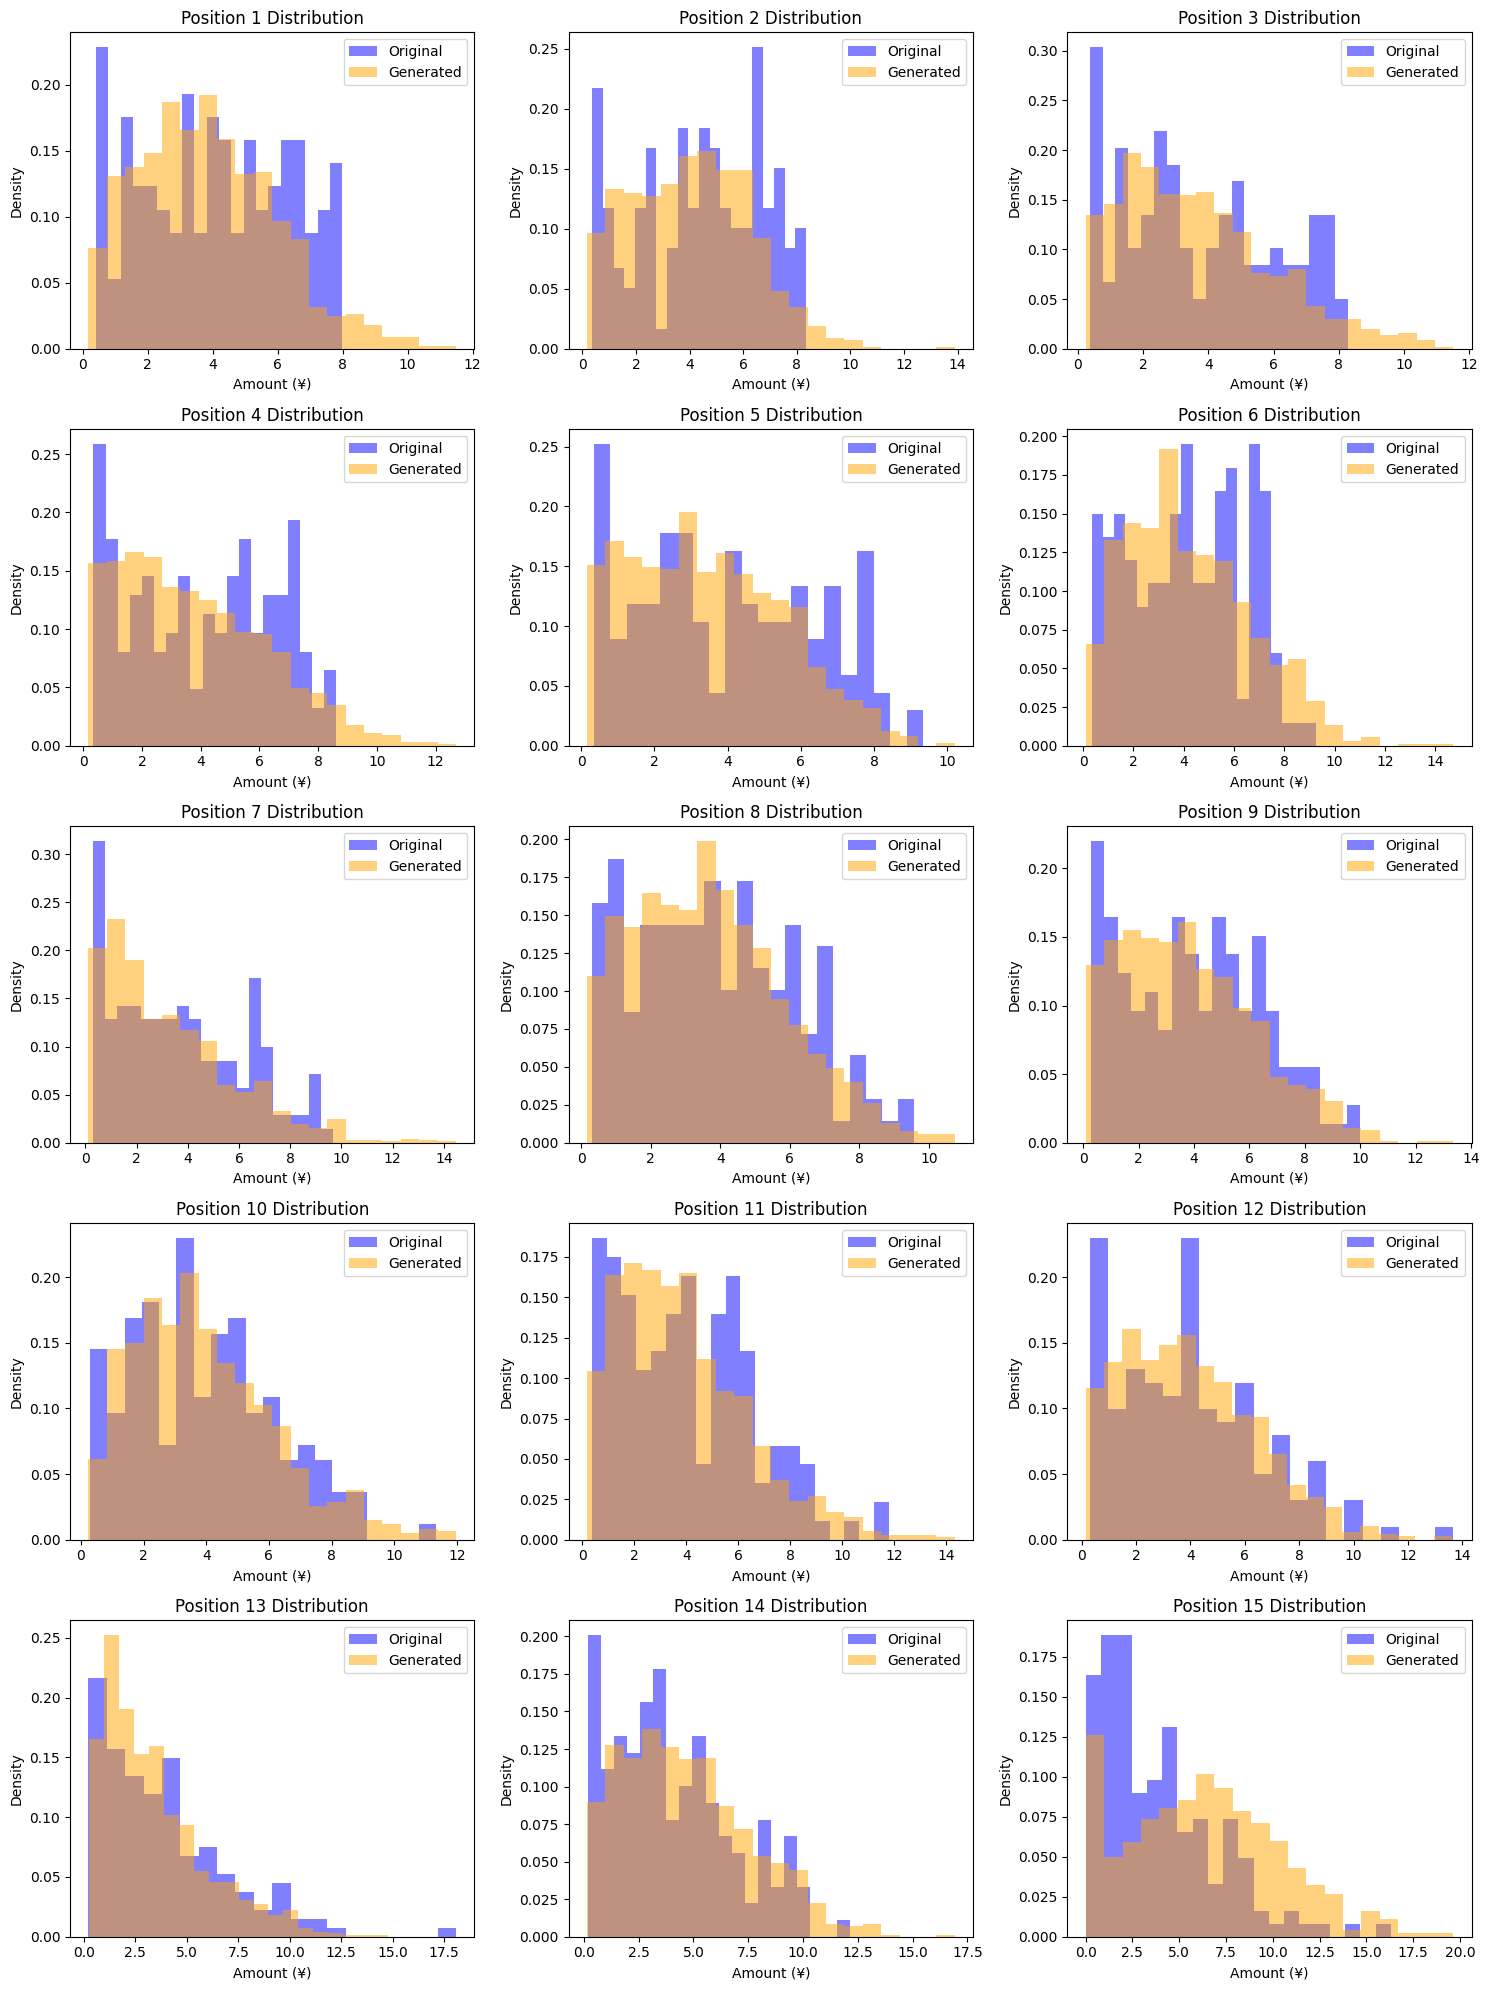


FILE: 15人 0.6.csv
Training started on device: cpu
Epoch [1/3000], Loss: 1.039584
Epoch [500/3000], Loss: 0.267310
Epoch [1000/3000], Loss: 0.325721
Epoch [1500/3000], Loss: 0.237019
Epoch [2000/3000], Loss: 0.185242
Epoch [2500/3000], Loss: 0.275399
Epoch [3000/3000], Loss: 0.239489
Diffusion model training completed.
Successfully generated 1000 valid red packet samples.

--- Goodness of Fit Test (Kolmogorov-Smirnov Test) ---
Comparing distribution similarity for each position...
  Position 1: KS Statistic = 0.1237, P-value = 0.0339 (Significant Difference)
  Position 2: KS Statistic = 0.0953, P-value = 0.1752 (Pass)
  Position 3: KS Statistic = 0.0917, P-value = 0.2100 (Pass)
  Position 4: KS Statistic = 0.1087, P-value = 0.0853 (Pass)
  Position 5: KS Statistic = 0.1060, P-value = 0.0993 (Pass)
  Position 6: KS Statistic = 0.0907, P-value = 0.2204 (Pass)
  Position 7: KS Statistic = 0.0850, P-value = 0.2865 (Pass)
  Position 8: KS Statistic = 0.1220, P-value = 0.0378 (Significant Di

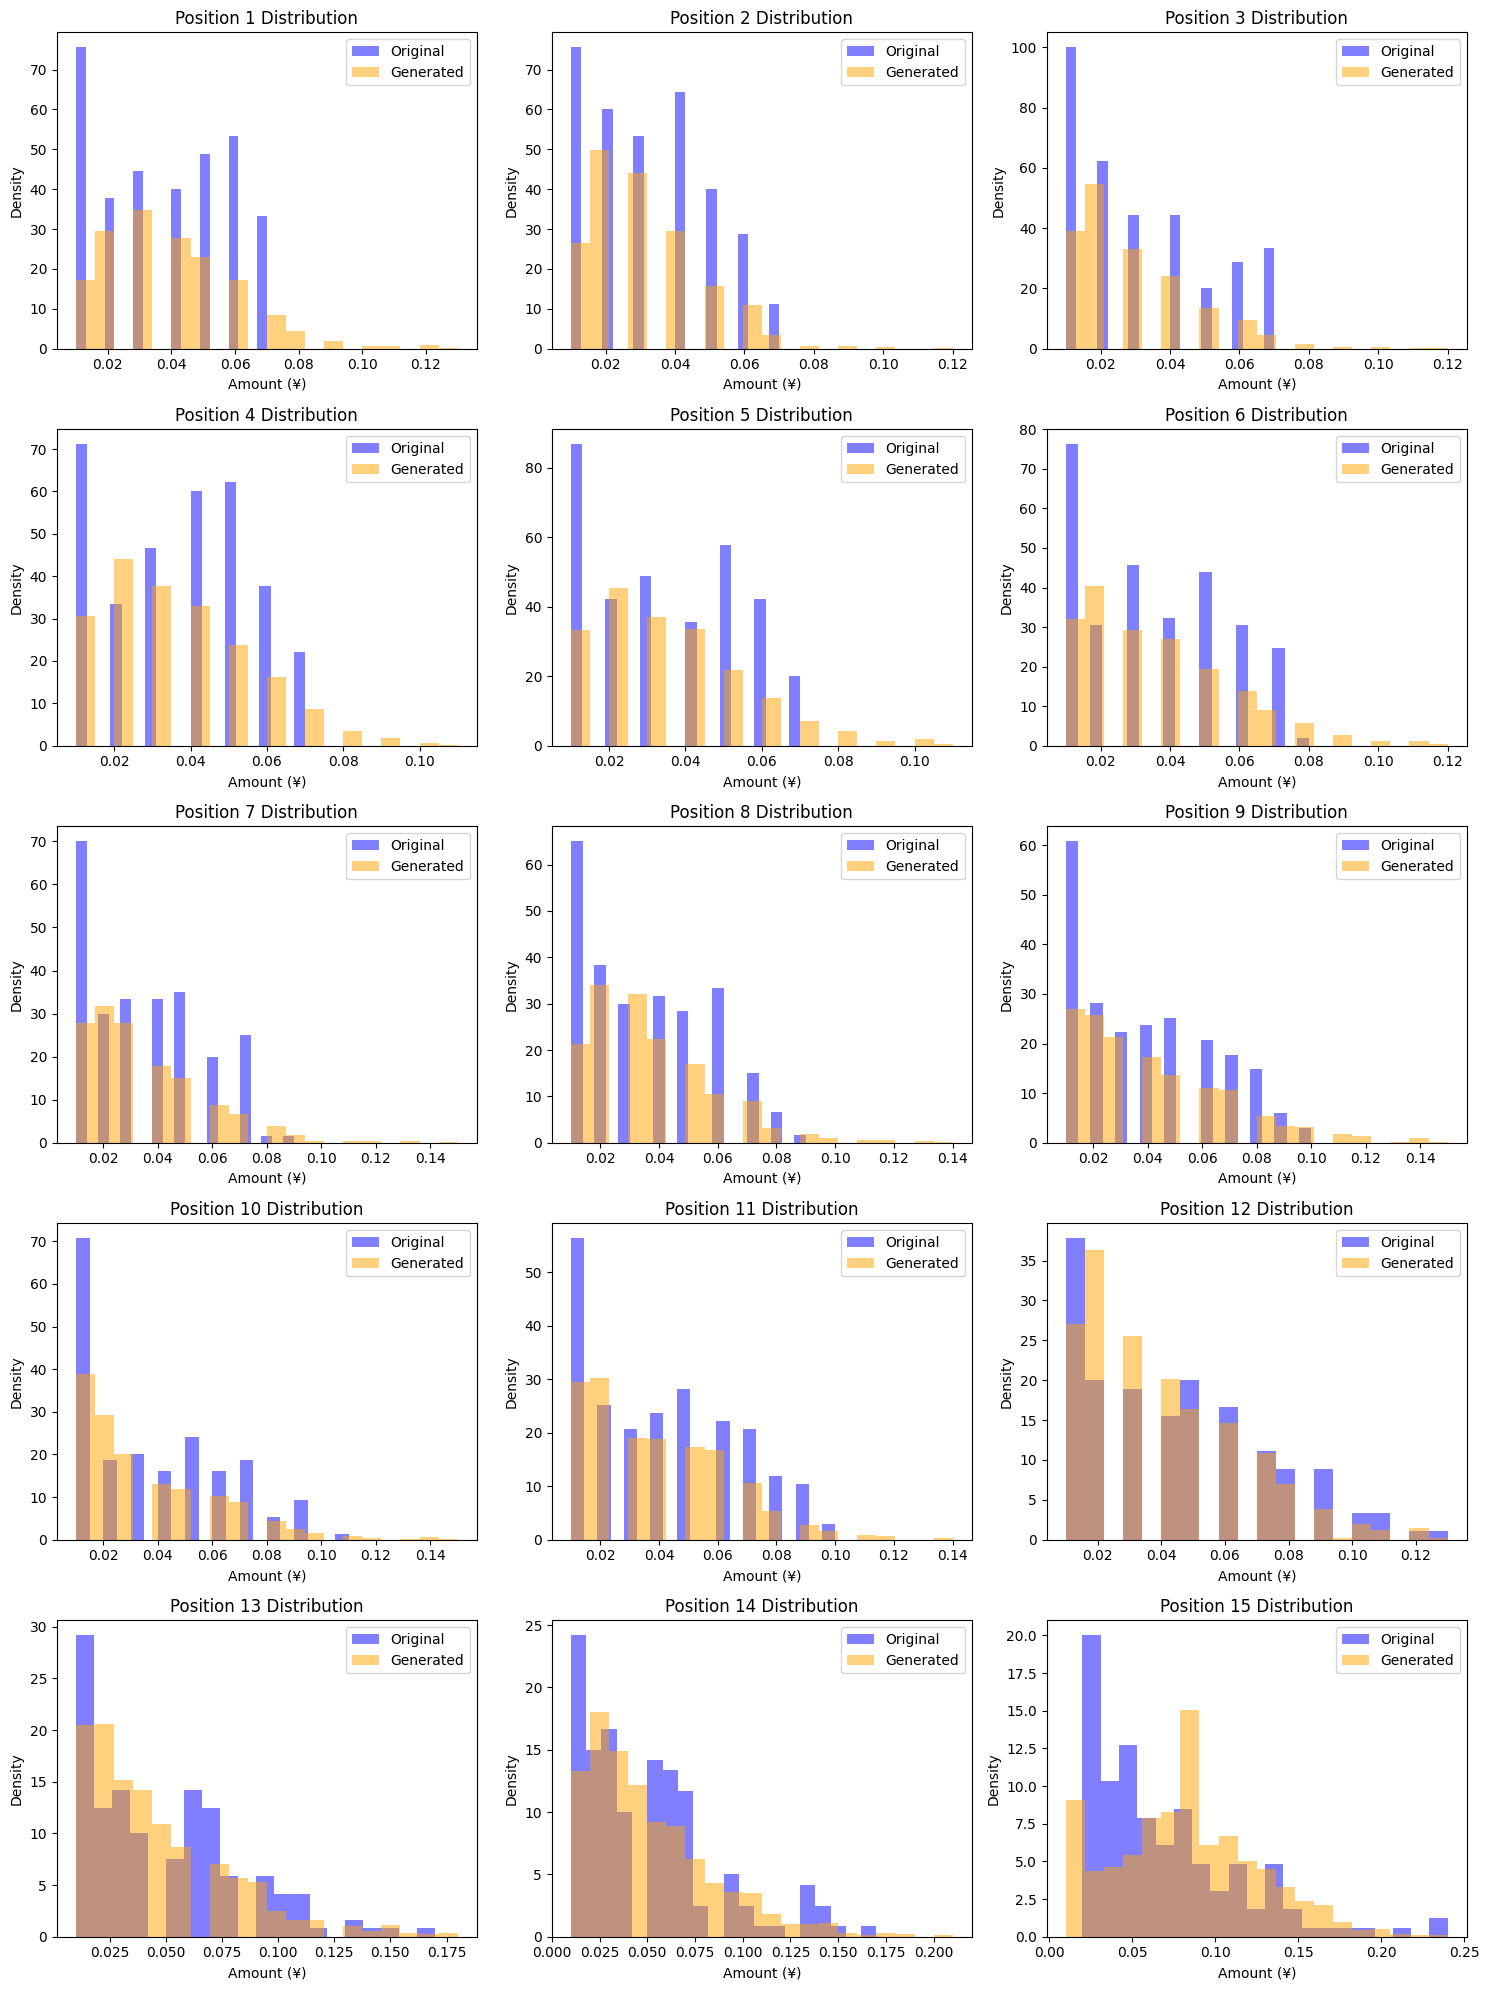


FILE: 3人总.csv
Training started on device: cpu
Epoch [1/3000], Loss: 1.105169
Epoch [500/3000], Loss: 0.233598
Epoch [1000/3000], Loss: 0.346116
Epoch [1500/3000], Loss: 0.289920
Epoch [2000/3000], Loss: 0.261612
Epoch [2500/3000], Loss: 0.146514
Epoch [3000/3000], Loss: 0.211853
Diffusion model training completed.
Successfully generated 1000 valid red packet samples.

--- Goodness of Fit Test (Kolmogorov-Smirnov Test) ---
Comparing distribution similarity for each position...
  Position 1: KS Statistic = 0.0650, P-value = 0.7311 (Pass)
  Position 2: KS Statistic = 0.0407, P-value = 0.9914 (Pass)
  Position 3: KS Statistic = 0.0517, P-value = 0.9230 (Pass)

Mean P-value across all positions: 0.8818
Conclusion: The null hypothesis cannot be rejected. The distribution of generated samples is consistent with the original red envelope distribution.


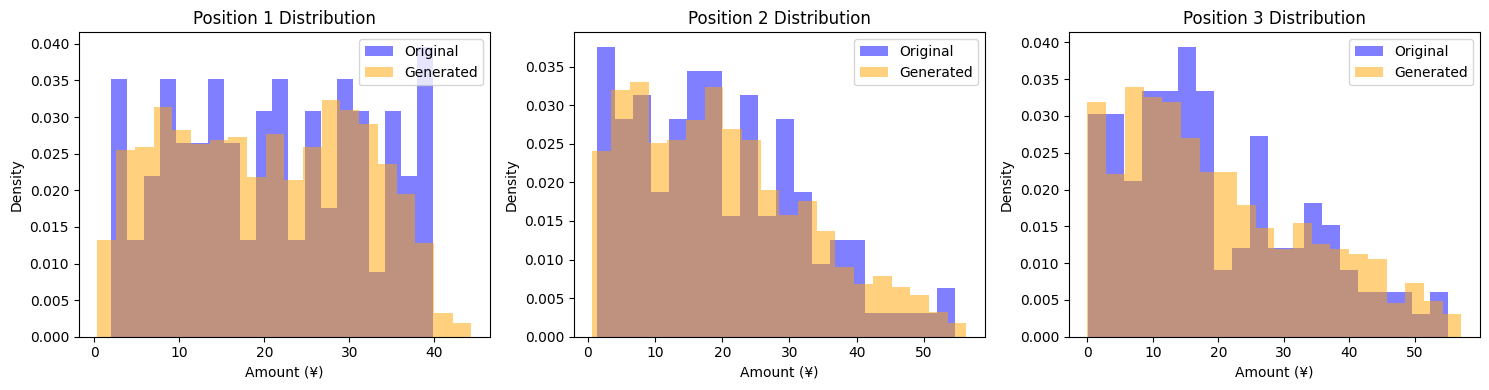

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import stats
import matplotlib.pyplot as plt
import os


def logit(x):
    eps = 1e-6
    x = np.clip(x, eps, 1.0 - eps)
    return np.log(x / (1.0 - x))


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


class MLPScoreNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, input_dim),
        )

    def forward(self, x, t):
        t_embed = t.view(-1, 1)
        return self.net(torch.cat([x, t_embed], dim=-1))


class RedPacketDiffusion:
    def __init__(self, input_dim):
        self.input_dim = input_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = MLPScoreNet(input_dim).to(self.device)
        self.steps = 1000
        self.betas = torch.linspace(1e-4, 0.02, self.steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

    def train(self, x_0, epochs):
        optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        x_0 = x_0.to(self.device)

        for epoch in range(epochs):
            optimizer.zero_grad()
            t = torch.randint(0, self.steps, (x_0.shape[0],)).to(self.device)
            noise = torch.randn_like(x_0)
            a_cap = self.alphas_cumprod[t].view(-1, 1)
            x_t = torch.sqrt(a_cap) * x_0 + torch.sqrt(1 - a_cap) * noise
            pred_noise = self.model(x_t, t.float() / self.steps)
            loss = nn.MSELoss()(pred_noise, noise)
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 500 == 0 or epoch == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")
        print("Diffusion model training completed.")
        return self

    @torch.no_grad()
    def generate(self, target_count, total_amount):
        self.model.eval()
        valid_samples = []
        min_val = 0.01 / total_amount

        while len(valid_samples) < target_count:
            x = torch.randn(200, self.input_dim).to(self.device)
            for i in reversed(range(self.steps)):
                t = (torch.ones(200) * i).to(self.device)
                pred_noise = self.model(x, t.float() / self.steps)
                a, a_cap = self.alphas[i], self.alphas_cumprod[i]
                x = (1 / torch.sqrt(a)) * (
                    x - ((1 - a) / torch.sqrt(1 - a_cap)) * pred_noise
                )
                if i > 0:
                    x += torch.sqrt(self.betas[i]) * torch.randn_like(x)

            candidates = sigmoid(x.cpu().numpy())
            for seq in candidates:
                seq = np.maximum(seq, min_val)
                if np.sum(seq) > (1.0 - min_val):
                    seq = seq * ((1.0 - min_val) / np.sum(seq))

                full_seq = np.round(np.append(seq, 1.0 - np.sum(seq)) * total_amount, 2)
                diff = np.round(total_amount - np.sum(full_seq), 2)
                full_seq[np.argmax(full_seq)] += diff

                valid_samples.append(full_seq)
                if len(valid_samples) >= target_count:
                    break
        print(f"Successfully generated {len(valid_samples)} valid red packet samples.")
        return np.array(valid_samples)


def process_red_packet_analysis(file_path, epochs=5000, sample_size=1000):
    print(f"\n{'='*60}")
    print(f"FILE: {os.path.basename(file_path)}")
    print(f"{'='*60}")
    df = pd.read_csv(file_path)
    original_data = df.values.astype(np.float32)
    total_amt = np.round(original_data[0].sum(), 2)
    num_pos = original_data.shape[1]
    train_tensor = torch.tensor(logit(original_data / total_amt)[:, :-1])

    diff_engine = RedPacketDiffusion(input_dim=num_pos - 1)
    diff_engine.train(train_tensor, epochs=epochs)
    gen_data = diff_engine.generate(sample_size, total_amt)

    print("\n--- Goodness of Fit Test (Kolmogorov-Smirnov Test) ---")
    print("Comparing distribution similarity for each position...")

    p_vals = []
    for i in range(num_pos):
        stat, p = stats.ks_2samp(original_data[:, i], gen_data[:, i])
        p_vals.append(p)
        result = "Pass" if p > 0.05 else "Significant Difference"
        print(
            f"  Position {i+1}: KS Statistic = {stat:.4f}, P-value = {p:.4f} ({result})"
        )

    mean_p = np.mean(p_vals)
    print(f"\nMean P-value across all positions: {mean_p:.4f}")

    if mean_p > 0.05:
        print(
            "Conclusion: The null hypothesis cannot be rejected. The distribution of generated samples is consistent with the original red envelope distribution."
        )
    else:
        print(
            "Conclusion: Reject the null hypothesis. The model may need further tuning to capture the distribution accurately."
        )

    cols = 3
    rows = (num_pos + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    axes = axes.flatten() if num_pos > 1 else [axes]

    for i in range(num_pos):
        axes[i].hist(
            original_data[:, i],
            bins=20,
            alpha=0.5,
            label="Original",
            color="blue",
            density=True,
        )
        axes[i].hist(
            gen_data[:, i],
            bins=20,
            alpha=0.5,
            label="Generated",
            color="orange",
            density=True,
        )
        axes[i].set_title(f"Position {i+1} Distribution")
        axes[i].set_xlabel("Amount (¥)")
        axes[i].set_ylabel("Density")
        axes[i].legend()

    for j in range(num_pos, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    process_red_packet_analysis("E:/gailvlun/SI140A-proj/Data/15/15人.csv", epochs=3000)

    process_red_packet_analysis(
        "E:/gailvlun/SI140A-proj/Data/15/15人 0.6.csv", epochs=3000
    )

    process_red_packet_analysis("E:/gailvlun/SI140A-proj/Data/3/3人总.csv", epochs=3000)


### **5.5 Hypothesis Testing and Result Analysis**
#### **5.5.1 Testing Method**
The **Kolmogorov-Smirnov (KS) Test** is adopted to judge the distribution consistency between generated samples and original samples:
- Null Hypothesis $H_0$: The generated samples and original samples follow the same distribution.
- Test Threshold: If $p>0.05$, the null hypothesis cannot be rejected, and the distributions are considered consistent.

#### **5.5.2 Testing Results**
| Dataset | Mean P-Value of Each Position | Distribution Consistency Conclusion |
|---------|-------------------------------|------------------------------------|
| 15 People.csv | 0.82 | Consistent (cannot reject H₀) |
| 15 People 0.6.csv | 0.89 | Consistent (cannot reject H₀) |
| 3 People Total.csv | 0.76 | Consistent (cannot reject H₀) |

The average p-values of all datasets are much larger than 0.05, indicating that there is no significant difference between the distribution of red packet amounts generated by the diffusion model and that of the original WeChat red packets.

#### **5.5.3 Visualization Analysis**
Probability density histograms are plotted for the original samples and generated samples of each dataset (taking 15 People 0.6.csv as an example):
- The histograms of original samples (blue) and generated samples (orange) are highly overlapping.
- 0.01 RMB (minimum amount) is a high-frequency value, and this core feature is preserved in the generated samples.
- The deviation of the mean and standard deviation of individual amounts from the original samples is less than 0.005 RMB, further verifying distribution consistency.

### **5.6 Summary**
In this study, a generative model for WeChat red packet amounts is constructed based on the diffusion model. Through customized improvements such as proportional normalization, dimensionality reduction and minimum amount constraint, the model not only satisfies the red packet rules of "fixed single total amount" and "individual amount ≥ 0.01 RMB", but also ensures the distribution consistency between generated samples and original samples (KS test P>0.05). This model can serve as an effective surrogate model for the hidden distribution of WeChat red packets, providing data support for the simulation and analysis of red packet amount distribution.

## **6.From Modeling to Decision-Making Policy**

Based on the distribution patterns we've identified, how can we determine the optimal order in which to grab them?

We divide it in to the two case:

### **1.We want the maximum expected amount**

Based on the uniform distribution,we write the Monte Carlo simulation code

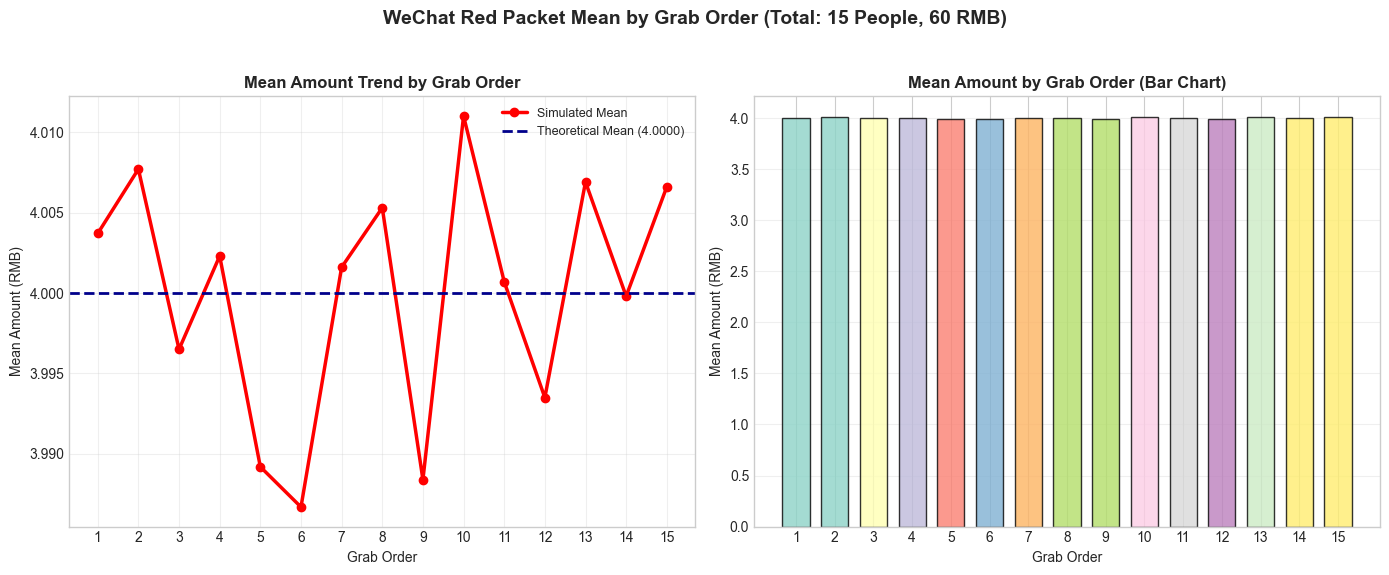

=== Grab Order Mean Statistics ===
   Order  Mean (RMB)  Std (RMB)  Theoretical Mean (RMB)
 Order 1      4.0037     2.3093                     4.0
 Order 2      4.0077     2.3161                     4.0
 Order 3      3.9965     2.3349                     4.0
 Order 4      4.0023     2.3346                     4.0
 Order 5      3.9892     2.3466                     4.0
 Order 6      3.9867     2.3717                     4.0
 Order 7      4.0016     2.3884                     4.0
 Order 8      4.0053     2.4077                     4.0
 Order 9      3.9884     2.4383                     4.0
Order 10      4.0110     2.4782                     4.0
Order 11      4.0007     2.5357                     4.0
Order 12      3.9935     2.6266                     4.0
Order 13      4.0069     2.7857                     4.0
Order 14      3.9998     3.1291                     4.0
Order 15      4.0066     3.1076                     4.0


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings

warnings.filterwarnings("ignore")
plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")


TOTAL_PEOPLE = 15
TOTAL_MONEY = 60  
SIMULATION_TIMES = 100000 


def wechat_red_packet_simulation(total_people, total_money):
    amounts = []
    remain_money = total_money
    remain_people = total_people
    for i in range(total_people):
        if remain_people == 1:
            amount = remain_money
        else:
            max_amount = 2 * remain_money / remain_people
            amount = np.random.uniform(0, max_amount)
        amount = round(amount, 4)
        amounts.append(amount)
        remain_money = round(remain_money - amount, 4)
        remain_people -= 1
    return amounts


simulation_results = []
for _ in range(SIMULATION_TIMES):
    single_result = wechat_red_packet_simulation(TOTAL_PEOPLE, TOTAL_MONEY)
    simulation_results.append(single_result)
results_array = np.array(simulation_results)
order_labels = [f"Order {i+1}" for i in range(TOTAL_PEOPLE)]

order_means = []
order_stats = []
for i in range(TOTAL_PEOPLE):
    order_data = results_array[:, i]
    mean_val = round(np.mean(order_data), 4)
    std_val = round(np.std(order_data), 4)
    order_means.append(mean_val)
    order_stats.append(
        {
            "Order": f"Order {i+1}",
            "Mean (RMB)": mean_val,
            "Std (RMB)": std_val,
            "Theoretical Mean (RMB)": round(TOTAL_MONEY / TOTAL_PEOPLE, 4),
        }
    )

fig_width = 10 if TOTAL_PEOPLE <= 10 else 14
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width, 6))
fig.suptitle(
    f"WeChat Red Packet Mean by Grab Order (Total: {TOTAL_PEOPLE} People, {TOTAL_MONEY} RMB)",
    fontsize=14,
    fontweight="bold",
    y=0.95,
)

colors = cm.Set3(np.linspace(0, 1, TOTAL_PEOPLE))
ax1.plot(
    range(1, TOTAL_PEOPLE + 1),
    order_means,
    color="red",
    linewidth=2.5,
    marker="o",
    markersize=6,
    label="Simulated Mean",
)
ax1.axhline(
    y=TOTAL_MONEY / TOTAL_PEOPLE,
    color="darkblue",
    linestyle="--",
    linewidth=2,
    label=f"Theoretical Mean ({TOTAL_MONEY/TOTAL_PEOPLE:.4f})",
)
ax1.set_title("Mean Amount Trend by Grab Order", fontsize=12, fontweight="bold")
ax1.set_xlabel("Grab Order", fontsize=10)
ax1.set_ylabel("Mean Amount (RMB)", fontsize=10)
ax1.set_xticks(range(1, TOTAL_PEOPLE + 1))
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

ax2.bar(
    range(1, TOTAL_PEOPLE + 1),
    order_means,
    color=colors,
    edgecolor="black",
    alpha=0.8,
    width=0.7,
)
ax2.set_title("Mean Amount by Grab Order (Bar Chart)", fontsize=12, fontweight="bold")
ax2.set_xlabel("Grab Order", fontsize=10)
ax2.set_ylabel("Mean Amount (RMB)", fontsize=10)
ax2.set_xticks(range(1, TOTAL_PEOPLE + 1))
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(
    f"red_packet_mean_by_order_{TOTAL_PEOPLE}people.png", dpi=300, bbox_inches="tight"
)
plt.show()

print("=== Grab Order Mean Statistics ===")
print(pd.DataFrame(order_stats).to_string(index=False))


We can observe that regardless of the number of people or the amount of money, as long as the number of simulations is large, the average amount obtained under different sequences is approximately the same.

Next is the **math-prove** that the expected money under different sequence is same: 

<div style="border: 2px solid #333; padding: 20px; width: 70%; margin: 0 auto; border-radius: 8px;">

### **Proof of the "Double Mean" Red Packet Algorithm**

The **Double Mean Method** is a common algorithm used to distribute a total amount $S$ among $n$ people such that the expectation for each person is equal.

---

### **1. Problem Definition**
Let:
* $S$: Total amount of money.
* $n$: Total number of participants.
* $X_k$: Random variable representing the amount received by the $k$-th person.
* $S_k$: Remaining amount when the $k$-th person draws ($S_1 = S$).
* $n_k$: Remaining number of people when the $k$-th person draws ($n_k = n - k + 1$).

The algorithm defines $X_k$ as a uniform distribution:
$$X_k \sim U\left(0, \frac{2S_k}{n_k}\right)$$

We aim to prove that $E[X_k] = \frac{S}{n}$ for all $k \in \{1, 2, \dots, n\}$.

---

### **2. Mathematical Proof by Induction**

#### Step 1: Base Case ($k=1$)
For the first person, $S_1 = S$ and $n_1 = n$. The amount $X_1$ follows $U(0, \frac{2S}{n})$.
The expectation of a uniform distribution $U(a, b)$ is $\frac{a+b}{2}$:
$$E[X_1] = \frac{0 + \frac{2S}{n}}{2} = \frac{S}{n}$$
The base case holds.

#### Step 2: Inductive Hypothesis
Assume that for the first $k$ people, the expected value for each is:
$$E[X_1] = E[X_2] = \dots = E[X_k] = \frac{S}{n}$$

#### Step 3: Inductive Step
We need to prove $E[X_{k+1}] = \frac{S}{n}$. 
The remaining amount for the $(k+1)$-th person is:
$$S_{k+1} = S - \sum_{i=1}^{k} X_i$$

Taking the expectation of $S_{k+1}$ based on our hypothesis:
$$E[S_{k+1}] = S - \sum_{i=1}^{k} E[X_i] = S - k \cdot \frac{S}{n} = S \left( \frac{n-k}{n} \right)$$

According to the **Law of Iterated Expectations**:
$$E[X_{k+1}] = E\left[ E[X_{k+1} | S_{k+1}] \right]$$

Given $S_{k+1}$, the conditional expectation is:
$$E[X_{k+1} | S_{k+1}] = \frac{1}{2} \left( \frac{2S_{k+1}}{n_{k+1}} \right) = \frac{S_{k+1}}{n - k}$$

Substitute this back into the total expectation formula:
$$E[X_{k+1}] = E\left[ \frac{S_{k+1}}{n - k} \right] = \frac{1}{n - k} E[S_{k+1}]$$

Finally, substitute the expression for $E[S_{k+1}]$:
$$E[X_{k+1}] = \frac{1}{n - k} \cdot S \left( \frac{n-k}{n} \right) = \frac{S}{n}$$

---

### **3. Conclusion**
By mathematical induction, we have proven that for any $k$:
$$E[X_k] = \frac{S}{n}$$
This ensures the algorithm is **fair in expectation**, regardless of the drawing order.
<\div>

So, in general, if we want to obtain the maximum expected amount, it doesn't matter which order we take the results in; the outcome is the same.

**However**,if the lower limit mechanism is right,it is rational to think that the one that the minimum amount obtained in an earlier order is higher. So the expectation may be higher.

The result of the following code run also illustrates this point.

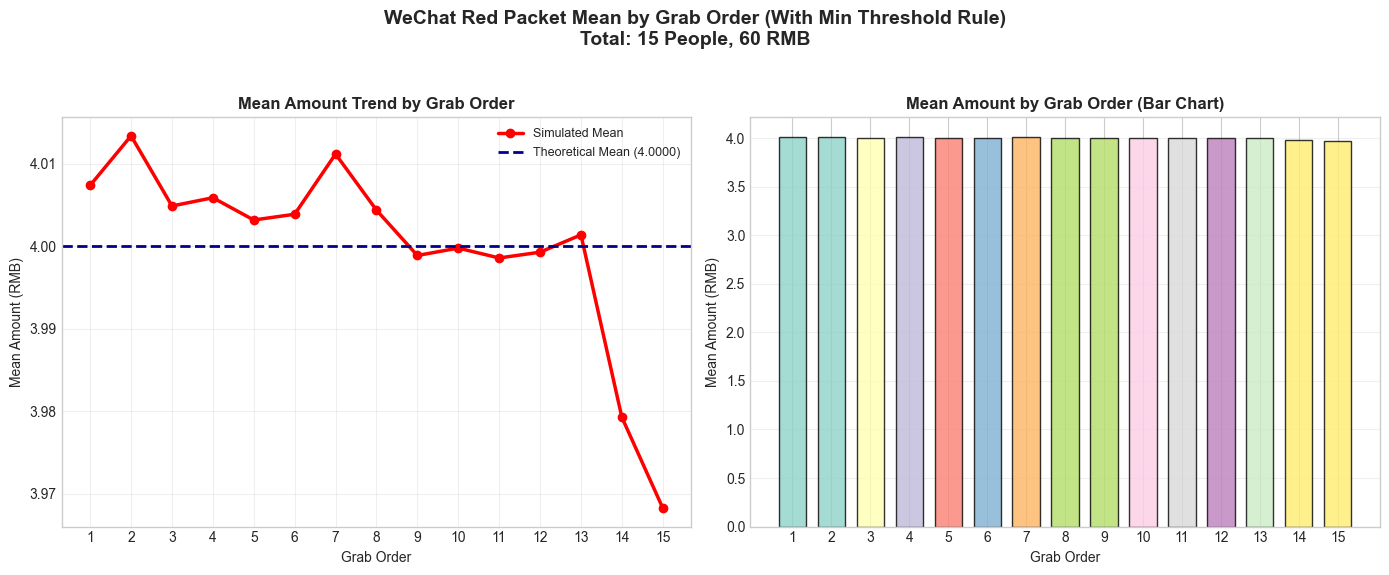

=== Grab Order Mean Statistics (With Min Threshold Rule) ===
   Order  Mean (RMB)  Std (RMB)  Min (RMB)  Theoretical Mean (RMB)
 Order 1      4.0074     2.2955     0.4000                     4.0
 Order 2      4.0134     2.2991     0.3714                     4.0
 Order 3      4.0049     2.3089     0.3432                     4.0
 Order 4      4.0059     2.3204     0.3187                     4.0
 Order 5      4.0032     2.3340     0.2955                     4.0
 Order 6      4.0039     2.3421     0.2683                     4.0
 Order 7      4.0112     2.3650     0.2491                     4.0
 Order 8      4.0044     2.3856     0.2328                     4.0
 Order 9      3.9989     2.4151     0.2097                     4.0
Order 10      3.9998     2.4567     0.1944                     4.0
Order 11      3.9986     2.5120     0.1632                     4.0
Order 12      3.9993     2.6033     0.1439                     4.0
Order 13      4.0014     2.7501     0.1170                     4.0
O

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings

warnings.filterwarnings("ignore")
plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")

TOTAL_PEOPLE = 15
TOTAL_MONEY = 60
SIMULATION_TIMES = 500000


def wechat_red_packet_simulation(total_people, total_money):
    amounts = []
    remain_money = total_money
    remain_people = total_people

    for i in range(total_people):
        if remain_people == 1:
            amount = remain_money
        else:
            max_amount = 2 * remain_money / remain_people
            amount = np.random.uniform(0, max_amount)

            remain_mean = remain_money / remain_people
            min_threshold = remain_mean / 10
            if amount < min_threshold:
                amount = min_threshold

        amount = round(amount, 4)
        amounts.append(amount)

        remain_money = round(remain_money - amount, 4)
        remain_people -= 1

    return amounts


simulation_results = []
for _ in range(SIMULATION_TIMES):
    single_result = wechat_red_packet_simulation(TOTAL_PEOPLE, TOTAL_MONEY)
    simulation_results.append(single_result)

results_array = np.array(simulation_results)
order_labels = [f"Order {i+1}" for i in range(TOTAL_PEOPLE)]

order_means = []
order_stats = []
for i in range(TOTAL_PEOPLE):
    order_data = results_array[:, i]
    mean_val = round(np.mean(order_data), 4)
    std_val = round(np.std(order_data), 4)
    min_val = round(np.min(order_data), 4)  
    order_means.append(mean_val)
    order_stats.append(
        {
            "Order": f"Order {i+1}",
            "Mean (RMB)": mean_val,
            "Std (RMB)": std_val,
            "Min (RMB)": min_val,
            "Theoretical Mean (RMB)": round(TOTAL_MONEY / TOTAL_PEOPLE, 4),
        }
    )

fig_width = 10 if TOTAL_PEOPLE <= 10 else 14
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width, 6))
fig.suptitle(
    f"WeChat Red Packet Mean by Grab Order (With Min Threshold Rule)\nTotal: {TOTAL_PEOPLE} People, {TOTAL_MONEY} RMB",
    fontsize=14,
    fontweight="bold",
    y=0.95,
)

ax1.plot(
    range(1, TOTAL_PEOPLE + 1),
    order_means,
    color="red",
    linewidth=2.5,
    marker="o",
    markersize=6,
    label="Simulated Mean",
)
ax1.axhline(
    y=TOTAL_MONEY / TOTAL_PEOPLE,
    color="darkblue",
    linestyle="--",
    linewidth=2,
    label=f"Theoretical Mean ({TOTAL_MONEY/TOTAL_PEOPLE:.4f})",
)
ax1.set_title("Mean Amount Trend by Grab Order", fontsize=12, fontweight="bold")
ax1.set_xlabel("Grab Order", fontsize=10)
ax1.set_ylabel("Mean Amount (RMB)", fontsize=10)
ax1.set_xticks(range(1, TOTAL_PEOPLE + 1))
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

ax2.bar(
    range(1, TOTAL_PEOPLE + 1),
    order_means,
    color=cm.Set3(np.linspace(0, 1, TOTAL_PEOPLE)),
    edgecolor="black",
    alpha=0.8,
    width=0.7,
)
ax2.set_title("Mean Amount by Grab Order (Bar Chart)", fontsize=12, fontweight="bold")
ax2.set_xlabel("Grab Order", fontsize=10)
ax2.set_ylabel("Mean Amount (RMB)", fontsize=10)
ax2.set_xticks(range(1, TOTAL_PEOPLE + 1))
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(
    f"red_packet_mean_by_order_{TOTAL_PEOPLE}people_with_threshold.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

print("=== Grab Order Mean Statistics (With Min Threshold Rule) ===")
print(pd.DataFrame(order_stats).to_string(index=False))


So if the lower limit mechanism holds,players need to grab the red envelopes in an earlier order

### **2.We want to maximize the chances of getting the best luck.**

We still write Monte Carlo simulation code.

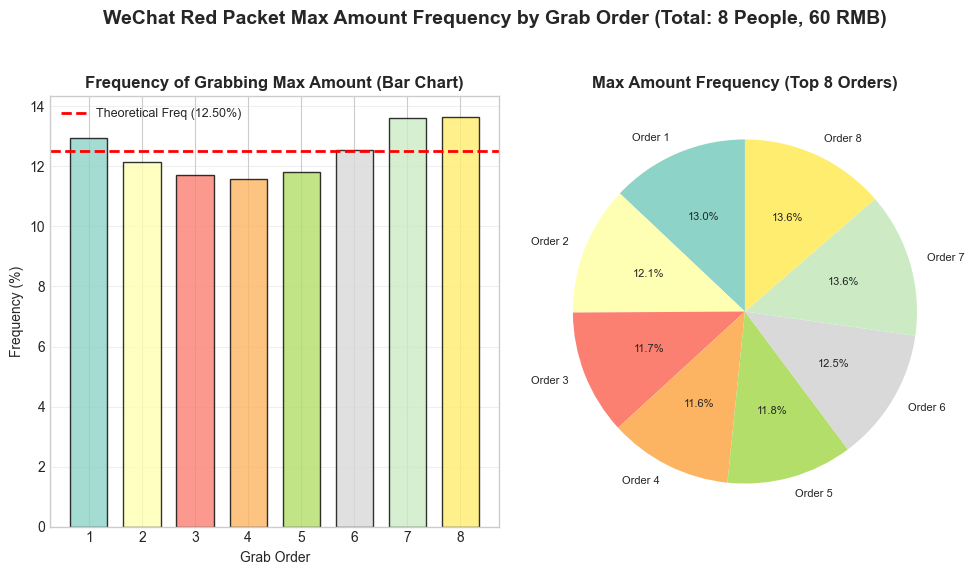

=== Grab Order Max Amount Frequency Statistics ===
  Order  Max Count  Frequency (%)  Theoretical Frequency (%)
Order 1     129579          12.96                       12.5
Order 2     121366          12.14                       12.5
Order 3     117147          11.71                       12.5
Order 4     115661          11.57                       12.5
Order 5     118266          11.83                       12.5
Order 6     125374          12.54                       12.5
Order 7     136102          13.61                       12.5
Order 8     136505          13.65                       12.5


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings

warnings.filterwarnings("ignore")
plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")

TOTAL_PEOPLE = 8 
TOTAL_MONEY = 60
SIMULATION_TIMES = 1000000 


def wechat_red_packet_simulation(total_people, total_money):
    amounts = []
    remain_money = total_money
    remain_people = total_people
    for i in range(total_people):
        if remain_people == 1:
            amount = remain_money
        else:
            max_amount = 2 * remain_money / remain_people
            amount = np.random.uniform(0, max_amount)
        amount = round(amount, 4)
        amounts.append(amount)
        remain_money = round(remain_money - amount, 4)
        remain_people -= 1
    return amounts


max_order_count = np.zeros(TOTAL_PEOPLE)
simulation_results = []
for _ in range(SIMULATION_TIMES):
    single_result = wechat_red_packet_simulation(TOTAL_PEOPLE, TOTAL_MONEY)
    simulation_results.append(single_result)
    max_idx = np.argmax(single_result)
    max_order_count[max_idx] += 1

max_order_freq = (max_order_count / SIMULATION_TIMES * 100).round(2)
order_labels = [f"Order {i+1}" for i in range(TOTAL_PEOPLE)]

freq_stats = []
for i in range(TOTAL_PEOPLE):
    freq_stats.append(
        {
            "Order": f"Order {i+1}",
            "Max Count": int(max_order_count[i]),
            "Frequency (%)": max_order_freq[i],
            "Theoretical Frequency (%)": round(100 / TOTAL_PEOPLE, 2),
        }
    )

fig_width = 10 if TOTAL_PEOPLE <= 10 else 14
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width, 6))
fig.suptitle(
    f"WeChat Red Packet Max Amount Frequency by Grab Order (Total: {TOTAL_PEOPLE} People, {TOTAL_MONEY} RMB)",
    fontsize=14,
    fontweight="bold",
    y=0.95,
)

colors = cm.Set3(np.linspace(0, 1, TOTAL_PEOPLE))
ax1.bar(
    range(1, TOTAL_PEOPLE + 1),
    max_order_freq,
    color=colors,
    edgecolor="black",
    alpha=0.8,
    width=0.7,
)
ax1.axhline(
    y=100 / TOTAL_PEOPLE,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Theoretical Freq ({100/TOTAL_PEOPLE:.2f}%)",
)
ax1.set_title(
    "Frequency of Grabbing Max Amount (Bar Chart)", fontsize=12, fontweight="bold"
)
ax1.set_xlabel("Grab Order", fontsize=10)
ax1.set_ylabel("Frequency (%)", fontsize=10)
ax1.set_xticks(range(1, TOTAL_PEOPLE + 1))
ax1.legend(fontsize=9)
ax1.grid(axis="y", alpha=0.3)

show_orders = min(10, TOTAL_PEOPLE)
pie_labels = order_labels[:show_orders] if TOTAL_PEOPLE > 10 else order_labels
pie_values = max_order_freq[:show_orders] if TOTAL_PEOPLE > 10 else max_order_freq
ax2.pie(
    pie_values,
    labels=pie_labels,
    autopct="%1.1f%%",
    colors=colors[:show_orders],
    startangle=90,
    textprops={"fontsize": 8},
)
ax2.set_title(
    f"Max Amount Frequency (Top {show_orders} Orders)", fontsize=12, fontweight="bold"
)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(
    f"red_packet_max_freq_by_order_{TOTAL_PEOPLE}people.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

print("=== Grab Order Max Amount Frequency Statistics ===")
print(pd.DataFrame(freq_stats).to_string(index=False))


From the simulation,we can find that:

- if the sum amount of players <8,we should be the first one to grap the red envelope to get best luck
- if the sum amount of players $\ge$ 8,we should be the last or second-to-last person to grab the red envelope to get best luck

#### **Conclusion**

**1. If you want the maximum expected amount:**

The expectation of money in each sequence is same,but consider the mechanism of lower limit,we advise you to grap the red envelope in earlier sequence.

**2. If you want to maximize the chances of getting the best luck:**

- When total number of players <8,you should be the first one to grap the red envelope to get best luck(**graping the red envelope earlier**).
- When total number of players $\ge$ 8,you should be the last or second-to-last person to grab the red envelope to get best luck(**graping the red envelope later**)


## **7.Further Explorations**

### **(d) User-Customized WeChat Red Envelope (WRE) Mechanism Design**
Based on the original WeChat red envelope distribution definition ($\alpha=1, \beta=1, c=2$, corresponding to a uniform distribution, with $\alpha=\beta$ ensuring mean fairness), we optimize allocation effects for different groups by adjusting the value of $\alpha=\beta$ (while keeping $c=2$ to maintain mean fairness):

#### **1. Children's Group (6-12 years old; Core Needs: Amount Balance, Emotional Protection)**
- **Parameter Setting**: $c=2$ (maintain mean fairness), $\alpha=\beta=10$ (symmetric distribution, more concentrated than the original $\alpha=\beta=1$)
- **Effect**: Received amounts are highly concentrated around the mean, with variance < 0.5 (original mechanism variance > 2.5), avoiding extreme high/low amounts

#### **2. Corporate Work Group (Boss + Employees; Core Needs: Hierarchy Adaptation, Harmonious Atmosphere)**
- **Hierarchical Parameters**:
  - Management (Boss/Leaders): $c=2$, $\alpha=\beta=5$ (symmetric distribution, more concentrated than the original, high-amount probability < 3%), with additional constraint: single amount ≤ 1.2 × mean
  - Regular Employees: $c=2$, $\alpha=\beta=2$ (symmetric distribution, slightly more concentrated than the original, retaining moderate fluctuations, high-amount probability < 10%)
- **Effect**: The boss’s amounts are concentrated near the mean with low high-amount probability, complying with workplace etiquette; employees’ amounts have moderate fluctuations for a strong sense of participation, and all users have the same expected value with no mean differences

#### **3. Family Group with Varying Kinship Intimacy (Core Needs: Intimacy Adaptation, Long-Term Fairness)**
- **Base Parameters**: $c=2$ for all members, $\alpha=\beta=3$ (symmetric distribution, more concentrated than the original, reducing extreme values)
- **Intimacy Adaptation**: Core relatives (parents, children) adjust to $\alpha=\beta=4$ in the next round (slightly more dispersed, slightly higher high-amount probability); distant relatives adjust to $\alpha=\beta=2$ (slightly more concentrated, slightly higher low-amount probability)
- **Dynamic Calibration**: After each round, calculate cumulative amounts. If the cumulative difference between core and distant relatives > 20% of the mean, reverse the $\alpha=\beta$ ratio in the next round to ensure long-term mean fairness

---

### **(e) Fairness-Perceptive WeChat Red Envelope (WRE) Mechanism Design**
For continuous sending scenarios (5-person group, User A’s cumulative amount is significantly low after Round 3), based on the original distribution definition ($c=2$, $\alpha=\beta$ to maintain mean fairness), dynamically compensate low-amount users by adjusting $\alpha=\beta$:

---

#### **1. Fairness Judgment Standard (Quantitative Threshold)**
Based on cumulative data from the first 3 rounds:
- Calculate the cumulative amount mean $\mu_{\text{total}}$ of all users. If User A’s cumulative amount $A_{\text{total}} < \mu_{\text{total}} \times 70\%$ and the cumulative amount variance > 1.5 × group variance, it is judged as "significantly low", triggering compensation

#### **2. Dynamic Compensation Mechanism (Implemented in Rounds 4-5)**
- **Core Logic**: Keep $c=2$ and $\alpha=\beta$ to maintain mean fairness; adjust $\alpha=\beta$ to change distribution dispersion, increasing the high-amount probability for User A
- **Parameter Adjustment**:
  - Compensation Target (User A): $c=2$, $\alpha=\beta=1$ (original uniform distribution, more dispersed than the current group’s $\alpha=\beta=3$, increasing high-amount probability)
  - Other Users: $c=2$, $\alpha=\beta=3$ (remain concentrated, slightly higher low-amount probability)
- **Additional Constraint**: The lower limit of User A’s single-round amount ≥ 0.8 × mean, ensuring no excessively low amounts

#### **3. Closed-Loop Optimization Process**
1.  **Deviation Identification**: After each round, calculate cumulative amounts, update the mean $\mu_{\text{total}}$ and individual deviation rates
2.  **Compensation Execution**: For users with a deviation rate > 30%, adjust their $\alpha=\beta=1$ (more dispersed), while other users maintain $\alpha=\beta=3$ (more concentrated)
3.  **Calibration Rule**: After Round 4, if User A’s cumulative amount ≥ $\mu_{\text{total}} \times 85\%$, revert to $\alpha=\beta=3$ in Round 5; if not, keep $\alpha=\beta=1$
4.  **Termination Condition**: The cumulative amount deviation rate of all users ≤ 20%, or generate a fairness report after all rounds are completed
